# Projet 6

In [2]:
import random
import os
# notre package de fonctionnalités
from Package import Scripts_Analyse01 as pk
from Package import Scripts_AnalyseMulti01 as pk_multi
from Package import Scripts_AnalyseMulti02_Unsupervised as pk_multi_unsp
import pandas as pd
import numpy as np
import missingno
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from umap import UMAP
from scipy.stats import pearsonr
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from yellowbrick.features import ParallelCoordinates
from plotly.graph_objects import Layout
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, scale
from sklearn.datasets import make_blobs
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.features import PCA as PCA_yellow
from yellowbrick.style import set_palette
from sklearn import metrics
import gc
import time
from contextlib import contextmanager
import warnings
import numpy as np
from datetime import datetime
from gql import gql, Client
from gql.transport.requests import RequestsHTTPTransport
from dotenv import load_dotenv
import nltk
from nltk import word_tokenize
from nltk.util import ngrams
import spacy
import re
from nltk.stem.snowball import SnowballStemmer
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
warnings.simplefilter(action='ignore', category=FutureWarning)
%load_ext pycodestyle_magic

In [3]:
from emot.emo_unicode import UNICODE_EMOJI as UNICODE_EMO# For emojis
from emot.emo_unicode import EMOTICONS_EMO# For EMOTICONS

In [ ]:
%flake8_off

ValueError: Function <bound method VarWatcher.auto_run_flake8 of <pycodestyle_magic.VarWatcher object at 0x0000028B7A2D1310>> is not registered as a post_run_cell callback

In [4]:
# chargement des variables d'environnment
load_dotenv() 

Python-dotenv could not parse statement starting at line 1


True

# Collecte des données

Uniquement API ? Les fichiers json ?

In [5]:
api_key = os.getenv('API_KEY')
endpoint = "https://api.yelp.com/v3/graphql"

Réalisons une fonction pour réaliser des requêtes en GraphQL. On utilise cette solution afin de pouvoir collecter les informations uniquement des champs qui nous intéressent.

In [6]:
def request_client(api_key, endpoint, query):
    reqHeaders = {
        'Authorization': 'Bearer ' + api_key 
    }

    _transport = RequestsHTTPTransport(
        url=endpoint,
        headers = reqHeaders,
        use_json=True,
    )

    client = Client(
        transport = _transport,
        fetch_schema_from_transport=True,
    )

    result = client.execute(query)
    return result

In [175]:
# le max de review est de 3 par restaurant, on importe toutes les données
restaurants=[]
j = 0
for i in range(0,8):
    query = """
                {
                search(term:"restaurant",
                        location: "France"
                        limit:50,
                        offset:"""+str(j)+"""
                        ) {
                    business {
                    id,
                    name,
                    photos,
                    reviews{
                        id,
                        text,
                        rating
                    }
                    }
                }
                }
            """
    query = gql(query)
    temp = request_client(api_key, endpoint, query)["search"]["business"]
    restaurants.extend(temp)
    print("nb restaurants ", len(restaurants))
    j=j+51
    

TransportQueryError: {'message': 'Something went wrong internally, please try again later.', 'locations': [{'line': 2, 'column': 3}], 'path': ['search'], 'extensions': {'code': 'INTERNAL_ERROR'}}

In [18]:
restaurants = pd.DataFrame(restaurants)

In [101]:
restaurants.head(2)

,id,name,photos,reviews
0,-0iLH7iQNYtoURciDpJf6w,Le Comptoir de la Gastronomie,[https://s3-media2.fl.yelpcdn.com/bphoto/TtMQl...,"[{'id': 'aGP7nLwEQOUg64jKP8ebsw', 'text': 'My ..."
1,IU9_wVOGBKjfqTTpAXpKcQ,Bistro des Augustins,[https://s3-media4.fl.yelpcdn.com/bphoto/J9RBy...,"[{'id': '-to6adg_kucf1SgQckgJXw', 'text': 'Thi..."


# Construction des bases de données

On scinde notre fichier en deux afin de traiter le texte et les photos séparément.

In [104]:
df = restaurants.copy()

In [105]:
df.head(2)

,id,name,photos,reviews
0,-0iLH7iQNYtoURciDpJf6w,Le Comptoir de la Gastronomie,[https://s3-media2.fl.yelpcdn.com/bphoto/TtMQl...,"[{'id': 'aGP7nLwEQOUg64jKP8ebsw', 'text': 'My ..."
1,IU9_wVOGBKjfqTTpAXpKcQ,Bistro des Augustins,[https://s3-media4.fl.yelpcdn.com/bphoto/J9RBy...,"[{'id': '-to6adg_kucf1SgQckgJXw', 'text': 'Thi..."


In [106]:
df['reviews'].apply(pd.Series)[0].apply(pd.Series)

,0,id,rating,text
0,NaN,aGP7nLwEQOUg64jKP8ebsw,5.0,My favorite meal in Paris! \n\nWe started off ...
1,NaN,-to6adg_kucf1SgQckgJXw,5.0,This is a small bar/restaurant closed to Cathé...
2,NaN,U8G3f8ITSlqBzETBDVO8bw,5.0,"Foods were delicious, great ambiance, and help..."
3,NaN,WMRKQUUR3BmjV_EZg7zVfw,5.0,"this is for a review from 2019, this place is ..."
4,NaN,giErkj8Al6-egq5XUu2FqA,5.0,Michelin starred. Reservations weeks in advanc...
...,...,...,...,...
195,NaN,APBAlRXsEX0-B_lwYXFSzw,4.0,"Paris, France\n\nHangry? \n\nWhen the most pop..."
196,NaN,37Klq0mvBK1WkxnhI0HRCg,5.0,Stopped here for dinner on our first night in ...
197,NaN,K--hr3q7hJFXuFvZbQTM7Q,5.0,Everything on the menu seems to be fully maste...
198,NaN,dkkicroZxI_fOiPW4B_GZw,5.0,My husband and I wanted to try a coq au vin wh...


In [50]:
df

,Unnamed: 0,id,name,photos,rw_id,rw_rating,rw_text
0,0,-0iLH7iQNYtoURciDpJf6w,Le Comptoir de la Gastronomie,['https://s3-media2.fl.yelpcdn.com/bphoto/TtMQ...,aGP7nLwEQOUg64jKP8ebsw,5.0,My favorite meal in Paris! \n\nWe started off ...
1,1,IU9_wVOGBKjfqTTpAXpKcQ,Bistro des Augustins,['https://s3-media4.fl.yelpcdn.com/bphoto/J9RB...,-to6adg_kucf1SgQckgJXw,5.0,This is a small bar/restaurant closed to Cathé...
2,2,KggnM_Z4wOa_JExunaaWHg,Le Temps des Cerises,['https://s3-media1.fl.yelpcdn.com/bphoto/g3Aa...,U8G3f8ITSlqBzETBDVO8bw,5.0,"Foods were delicious, great ambiance, and help..."
3,3,WHHt_Jb8Tgidn9mW7oDnIg,La Coïncidence,['https://s3-media1.fl.yelpcdn.com/bphoto/QdrA...,WMRKQUUR3BmjV_EZg7zVfw,5.0,"this is for a review from 2019, this place is ..."
4,4,_qACPRqSQ6Nvd20H8EY3uw,Frenchie Restaurant,['https://s3-media2.fl.yelpcdn.com/bphoto/E8EG...,giErkj8Al6-egq5XUu2FqA,5.0,Michelin starred. Reservations weeks in advanc...
...,...,...,...,...,...,...,...
195,195,26YjCdVvyn5jv4sZYd1Lvw,Loup,['https://s3-media2.fl.yelpcdn.com/bphoto/M1pg...,APBAlRXsEX0-B_lwYXFSzw,4.0,"Paris, France\n\nHangry? \n\nWhen the most pop..."
196,196,MN-I5rJBYAZwp2jeHXs_JQ,L'Alsacien,['https://s3-media3.fl.yelpcdn.com/bphoto/Um1i...,37Klq0mvBK1WkxnhI0HRCg,5.0,Stopped here for dinner on our first night in ...
197,197,fK5KhHO8az5LVmzOPsED2g,Miznon,['https://s3-media3.fl.yelpcdn.com/bphoto/q_AO...,K--hr3q7hJFXuFvZbQTM7Q,5.0,Everything on the menu seems to be fully maste...
198,198,R44YZMAdHQFB9BCIUcwnhA,Machon d'Henri Le,['https://s3-media1.fl.yelpcdn.com/bphoto/n6_5...,dkkicroZxI_fOiPW4B_GZw,5.0,My husband and I wanted to try a coq au vin wh...


In [108]:
df = pd.concat([df.drop(['reviews'], axis=1), 
    df['reviews'].apply(pd.Series)[0].apply(pd.Series)]
    , axis=1)


In [109]:
df.columns

Index(['id', 'name', 'photos', 0, 'id', 'rating', 'text'], dtype='object')

In [110]:
df.columns = ['id', 'name', 'photos','pb', 'rw_id', 
          'rw_rating','rw_text']

In [111]:
del df["pb"]

Exportons les données en csv

In [112]:
df.to_csv('output/restaurants_v2.csv')

Requête pour importer les données.

In [213]:
df = pd.read_csv('output/restaurants_v2.csv')

In [214]:
df
#del df["Unnamed: 0"]

,Unnamed: 0,id,name,photos,rw_id,rw_rating,rw_text
0,0,-0iLH7iQNYtoURciDpJf6w,Le Comptoir de la Gastronomie,['https://s3-media2.fl.yelpcdn.com/bphoto/TtMQlDyy7QUF4fDaxvqljg/o.jpg'],aGP7nLwEQOUg64jKP8ebsw,5.0,My favorite meal in Paris! \n\nWe started off with the foie gras carpaccio and escargot. Love th...
1,1,IU9_wVOGBKjfqTTpAXpKcQ,Bistro des Augustins,['https://s3-media4.fl.yelpcdn.com/bphoto/J9RByC4HuTubBKX77PYeEg/o.jpg'],-to6adg_kucf1SgQckgJXw,5.0,This is a small bar/restaurant closed to Cathédrale Notre Dame. I always come here for lunch or ...
2,2,KggnM_Z4wOa_JExunaaWHg,Le Temps des Cerises,['https://s3-media1.fl.yelpcdn.com/bphoto/g3AabbeUo_jMvM2jjSH1XQ/o.jpg'],U8G3f8ITSlqBzETBDVO8bw,5.0,"Foods were delicious, great ambiance, and helpful staffs. \nThe risotto cooked perfectly! I got ..."
3,3,WHHt_Jb8Tgidn9mW7oDnIg,La Coïncidence,['https://s3-media1.fl.yelpcdn.com/bphoto/QdrAgEgbd5TLlqZYT_dezg/o.jpg'],WMRKQUUR3BmjV_EZg7zVfw,5.0,"this is for a review from 2019, this place is perfect. would recommend 100%. prices are great, f..."
4,4,_qACPRqSQ6Nvd20H8EY3uw,Frenchie Restaurant,['https://s3-media2.fl.yelpcdn.com/bphoto/E8EGlQnkJX4Z1SnsW_-qtg/o.jpg'],giErkj8Al6-egq5XUu2FqA,5.0,Michelin starred. Reservations weeks in advance is absolutely necessary to dine at an establishm...
...,...,...,...,...,...,...,...
195,195,26YjCdVvyn5jv4sZYd1Lvw,Loup,['https://s3-media2.fl.yelpcdn.com/bphoto/M1pgSeZdPeuNqkElQiBg9A/o.jpg'],APBAlRXsEX0-B_lwYXFSzw,4.0,"Paris, France\n\nHangry? \n\nWhen the most popular places are packed Au Pied du Cochon for insta..."
196,196,MN-I5rJBYAZwp2jeHXs_JQ,L'Alsacien,['https://s3-media3.fl.yelpcdn.com/bphoto/Um1ianYa4Ja71KXQyg1g9Q/o.jpg'],37Klq0mvBK1WkxnhI0HRCg,5.0,Stopped here for dinner on our first night in gai Paris. We stayed in the the 5th arrondissement...
197,197,fK5KhHO8az5LVmzOPsED2g,Miznon,['https://s3-media3.fl.yelpcdn.com/bphoto/q_AOt2rkWrL90Wg3IC5Y7g/o.jpg'],K--hr3q7hJFXuFvZbQTM7Q,5.0,"Everything on the menu seems to be fully mastered, the flavors are amazing at a very affordable ..."
198,198,R44YZMAdHQFB9BCIUcwnhA,Machon d'Henri Le,['https://s3-media1.fl.yelpcdn.com/bphoto/n6_5YZ8qq1rM63H6-xUKaQ/o.jpg'],dkkicroZxI_fOiPW4B_GZw,5.0,"My husband and I wanted to try a coq au vin while we were in France. Unfortunately, what we didn..."


In [215]:
reviews = df[["rw_id", "rw_rating", "rw_text"]].copy()

In [216]:
reviews["rw_rating"].unique()

array([ 5.,  4., nan,  3.,  1.])

In [217]:
photos = df[["id", "photos"]]

# Analyse des données

## Pré traitement des données textuelles

Analysons le texte en premier lieu

In [28]:
reviews

,rw_id,rw_rating,rw_text
0,aGP7nLwEQOUg64jKP8ebsw,5.0,My favorite meal in Paris! \n\nWe started off ...
1,-to6adg_kucf1SgQckgJXw,5.0,This is a small bar/restaurant closed to Cathé...
2,U8G3f8ITSlqBzETBDVO8bw,5.0,"Foods were delicious, great ambiance, and help..."
3,WMRKQUUR3BmjV_EZg7zVfw,5.0,"this is for a review from 2019, this place is ..."
4,giErkj8Al6-egq5XUu2FqA,5.0,Michelin starred. Reservations weeks in advanc...
...,...,...,...
195,APBAlRXsEX0-B_lwYXFSzw,4.0,"Paris, France\n\nHangry? \n\nWhen the most pop..."
196,37Klq0mvBK1WkxnhI0HRCg,5.0,Stopped here for dinner on our first night in ...
197,K--hr3q7hJFXuFvZbQTM7Q,5.0,Everything on the menu seems to be fully maste...
198,dkkicroZxI_fOiPW4B_GZw,5.0,My husband and I wanted to try a coq au vin wh...


Regardons le nombre de commentaire par note. Traçons un diagramme en barre

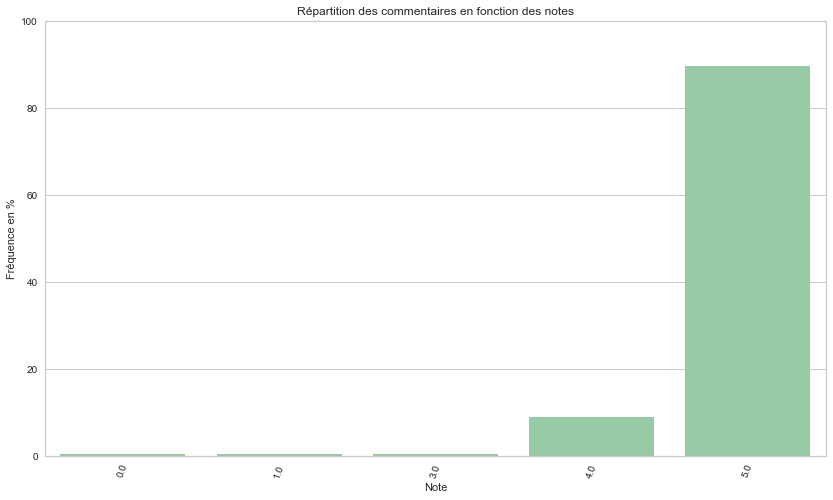

In [66]:
pk.graph_barplot(reviews['rw_rating'],
                  "Répartition des commentaires en fonction des notes", 
                   (0.564, 0.823, 0.631),
                   0, 100, "Note", "Fréquence en %",70, 1, (14,8))

In [67]:
reviews['rw_rating'].describe()

count    200.000000
mean       4.855000
std        0.543555
min        0.000000
25%        5.000000
50%        5.000000
75%        5.000000
max        5.000000
Name: rw_rating, dtype: float64

Le but est de découvrir les sujets insatisfaisants, nous commençons par compter le nombre de mots.

In [40]:
reviews

,rw_id,rw_rating,rw_text
0,aGP7nLwEQOUg64jKP8ebsw,5.0,My favorite meal in Paris! \n\nWe started off ...
1,-to6adg_kucf1SgQckgJXw,5.0,This is a small bar/restaurant closed to Cathé...
2,U8G3f8ITSlqBzETBDVO8bw,5.0,"Foods were delicious, great ambiance, and help..."
3,WMRKQUUR3BmjV_EZg7zVfw,5.0,"this is for a review from 2019, this place is ..."
4,giErkj8Al6-egq5XUu2FqA,5.0,Michelin starred. Reservations weeks in advanc...
...,...,...,...
195,APBAlRXsEX0-B_lwYXFSzw,4.0,"Paris, France\n\nHangry? \n\nWhen the most pop..."
196,37Klq0mvBK1WkxnhI0HRCg,5.0,Stopped here for dinner on our first night in ...
197,K--hr3q7hJFXuFvZbQTM7Q,5.0,Everything on the menu seems to be fully maste...
198,dkkicroZxI_fOiPW4B_GZw,5.0,My husband and I wanted to try a coq au vin wh...


In [41]:
reviews["rw_text"]

0      My favorite meal in Paris! \n\nWe started off ...
1      This is a small bar/restaurant closed to Cathé...
2      Foods were delicious, great ambiance, and help...
3      this is for a review from 2019, this place is ...
4      Michelin starred. Reservations weeks in advanc...
                             ...                        
195    Paris, France\n\nHangry? \n\nWhen the most pop...
196    Stopped here for dinner on our first night in ...
197    Everything on the menu seems to be fully maste...
198    My husband and I wanted to try a coq au vin wh...
199    Hard to find a nice French restaurant without ...
Name: rw_text, Length: 200, dtype: object

Nous observons des retours à la ligne "\n" et la présence de ponctuation dans le texte. Il faut donc supprimer ces caractères. Cependant, il faut faire attention car il se peut qu'il y ait des smileys.
Créons une fonction pour traiter le texte.

In [218]:
def text_cleaning(text, ponct, only_letters, numbers):
    text = text.lower()
    ponctuation = "[^!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~]"
    number = "[^0-9]"
    letters = "[^a-zA-Z ]"
    if ponct == 1:
        text = re.sub(ponctuation, '', text)
    if only_letters == 1:
        text = re.sub(letters, '', text)
    if numbers == 1:
        text = re.sub(number, '', text)
    return text

<>:3: DeprecationWarning:

invalid escape sequence \]

<>:3: DeprecationWarning:

invalid escape sequence \]

C:\Users\aurel\AppData\Local\Temp\ipykernel_8832\2782372609.py:3: DeprecationWarning:

invalid escape sequence \]



In [219]:
# Function for converting emojis into word
def convert_emojis(text):
    for emot in UNICODE_EMO:
        text = text.replace(emot, "_".join(UNICODE_EMO[emot].replace(",","").replace(":","").split()))
    return text# Example


In [220]:
text1 = "Hilarious :) 😂. The feeling of making a sale 😎, The feeling of actually fulfilling orders 😒"
convert_emojis(text1)

'Hilarious :) face_with_tears_of_joy. The feeling of making a sale smiling_face_with_sunglasses, The feeling of actually fulfilling orders unamused_face'

In [221]:
def convert_emoticons(text):
    for emot in EMOTICONS_EMO:
        text = text.replace(emot, EMOTICONS_EMO[emot].replace(" ","_"))
    return text


text = "Hello :-) :-)"
convert_emoticons(text)

'Hello Happy_face_smiley Happy_face_smiley'

Réécrivons les contractions en entier.

In [222]:
import contractions

test = contractions.fix("shouldn't")
test

'should not'

Nous avons des commentaires vides, nous décidons de mettre 0 pour les notes et un vide pour les valeurs Nan des commentaires.

In [223]:
reviews["rw_text"] = reviews["rw_text"].fillna("")

In [224]:
reviews["rw_rating"] = reviews["rw_rating"].fillna(0)

In [225]:
reviews["rw_text"] = reviews["rw_text"].str.lower()
for index, element in reviews.iterrows():
    #tokenizer = nltk.RegexpTokenizer(r'\w+')
    element["rw_text"] = convert_emojis(element["rw_text"])
    element["rw_text"] = convert_emoticons(element["rw_text"])
    element["rw_text"] = text_cleaning(element["rw_text"],0 , 1, 0)
    element["rw_text"] = contractions.fix(element["rw_text"])
    #tokens = tokenizer.tokenize(element["rw_text"])
    tokens = element["rw_text"].split()
    reviews.loc[index, "rw_text"] = element["rw_text"]
    reviews.loc[index, "nb_words"] = len(tokens)
    reviews.loc[index, "words"] = str(tokens)

In [226]:
reviews

,rw_id,rw_rating,rw_text,nb_words,words
0,aGP7nLwEQOUg64jKP8ebsw,5.0,my favorite meal in paris we started off with the foie gras carpaccio and escargot love the uniq...,28.0,"['my', 'favorite', 'meal', 'in', 'paris', 'we', 'started', 'off', 'with', 'the', 'foie', 'gras',..."
1,-to6adg_kucf1SgQckgJXw,5.0,this is a small barrestaurant closed to cathdrale notre dame i always come here for lunch or din...,29.0,"['this', 'is', 'a', 'small', 'barrestaurant', 'closed', 'to', 'cathdrale', 'notre', 'dame', 'i',..."
2,U8G3f8ITSlqBzETBDVO8bw,5.0,foods were delicious great ambiance and helpful staffs the risotto cooked perfectly i got the wh...,24.0,"['foods', 'were', 'delicious', 'great', 'ambiance', 'and', 'helpful', 'staffs', 'the', 'risotto'..."
3,WMRKQUUR3BmjV_EZg7zVfw,5.0,this is for a review from this place is perfect would recommend prices are great food is astou...,22.0,"['this', 'is', 'for', 'a', 'review', 'from', 'this', 'place', 'is', 'perfect', 'would', 'recomme..."
4,giErkj8Al6-egq5XUu2FqA,5.0,michelin starred reservations weeks in advance is absolutely necessary to dine at an establishme...,23.0,"['michelin', 'starred', 'reservations', 'weeks', 'in', 'advance', 'is', 'absolutely', 'necessary..."
...,...,...,...,...,...
195,APBAlRXsEX0-B_lwYXFSzw,4.0,paris francehangry when the most popular places are packed au pied du cochon for instance and yo...,26.0,"['paris', 'francehangry', 'when', 'the', 'most', 'popular', 'places', 'are', 'packed', 'au', 'pi..."
196,37Klq0mvBK1WkxnhI0HRCg,5.0,stopped here for dinner on our first night in gai paris we stayed in the the th arrondissements ...,29.0,"['stopped', 'here', 'for', 'dinner', 'on', 'our', 'first', 'night', 'in', 'gai', 'paris', 'we', ..."
197,K--hr3q7hJFXuFvZbQTM7Q,5.0,everything on the menu seems to be fully mastered the flavors are amazing at a very affordable p...,28.0,"['everything', 'on', 'the', 'menu', 'seems', 'to', 'be', 'fully', 'mastered', 'the', 'flavors', ..."
198,dkkicroZxI_fOiPW4B_GZw,5.0,my husband and i wanted to try a coq au vin while we were in france unfortunately what we did no...,34.0,"['my', 'husband', 'and', 'i', 'wanted', 'to', 'try', 'a', 'coq', 'au', 'vin', 'while', 'we', 'we..."


In [157]:
graph = reviews.sort_values(by='nb_words', ascending=False)
pk.graph_intv_bar(graph, 'rw_id', 'nb_words', "rw_id", "nb words", 'redor', "Nombre de mots par commentaire")

In [158]:
reviews["nb_words"].describe()

count    200.000000
mean      27.205000
std        3.649599
min        0.000000
25%       25.000000
50%       28.000000
75%       30.000000
max       34.000000
Name: nb_words, dtype: float64

Nous avons en moyenne 26 mots par commentaire. Et 50% des commentaires font plus de 27 mots.

Regardons les mots les plus fréquents

In [227]:
words = nltk.tokenize.word_tokenize(" ".join(reviews['rw_text']))

In [228]:
word_dist = nltk.FreqDist(words)



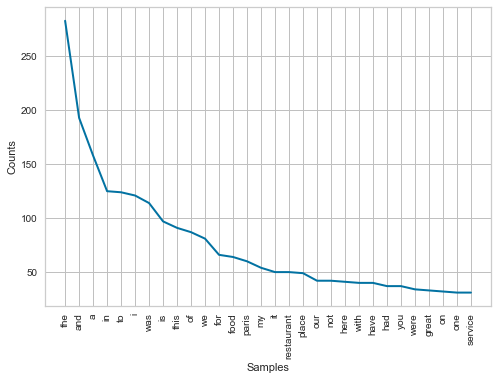

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [161]:
fdist = nltk.FreqDist(words)
fdist.plot(30)

Nous observons qu'il y a des déterminants de type : the, in, a qui sont très fréquent.
Nous devons supprimer ces mots car il n'apporte pas d'informations sur le sujet ou le sentiment du commentaire.

Réalisons une fonction pour compter le nombre de mot et faire le graphique

In [21]:
def nb_most_frequent_plt(df_var):
    words = nltk.tokenize.word_tokenize(" ".join(df_var))
    fdist = nltk.FreqDist(words)
    fdist.plot(30)

In [22]:
gc.collect()

1116

Essayons d'utiliser la bibliothèque nltk

In [229]:
from nltk.corpus import stopwords
nltk.download('stopwords')

sw_nltk = stopwords.words('english')
print(sw_nltk)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aurel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Dans la liste stopwords du package, il y a des mots qui sont importants pour l'identification des sentiments comme "very" ou les négations ("not"...).
Supprimons ces éléments de la liste de stopwords. De plus, le package supprime certains verbes comme be et have. Nous voulons garder ces verbes pour l'analyse de sentiment.

In [230]:
keep_words = ["you're", "you've", "you'd", "she's", "it's", 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'not', 
              'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'but', 'if', 'because', 'against', 'between', 
              'during', 'before', 'after', 'again', 'once', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 
              'such', 'only', 'own', 'same', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 
              'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 
              'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', 
              "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]
new_sw_nltk = [word for word in sw_nltk if word not in keep_words]

new_sw_nltk.extend(['th','pm', 's', 'er', 'paris', 'rst', 'st', 'am'])

Ces mots n'apportent pas de sens concernant les sentiments dans les phrases. Autrement dit, ce sont des mots dit vides pour notre projet.

In [231]:
pat = r'\b(?:{})\b'.format('|'.join(new_sw_nltk))
cleaning = reviews['rw_text'].str.replace(pat, '')
reviews['new_words'] = cleaning.apply(lambda x: nltk.word_tokenize(x))
reviews['new_text'] = cleaning



In [232]:
reviews

,rw_id,rw_rating,rw_text,nb_words,words,new_words,new_text
0,aGP7nLwEQOUg64jKP8ebsw,5.0,my favorite meal in paris we started off with the foie gras carpaccio and escargot love the uniq...,28.0,"['my', 'favorite', 'meal', 'in', 'paris', 'we', 'started', 'off', 'with', 'the', 'foie', 'gras',...","[favorite, meal, started, foie, gras, carpaccio, escargot, love, unique, way, foie, gras, was, p...",favorite meal started foie gras carpaccio escargot love unique way foie gras was prep...
1,-to6adg_kucf1SgQckgJXw,5.0,this is a small barrestaurant closed to cathdrale notre dame i always come here for lunch or din...,29.0,"['this', 'is', 'a', 'small', 'barrestaurant', 'closed', 'to', 'cathdrale', 'notre', 'dame', 'i',...","[is, small, barrestaurant, closed, cathdrale, notre, dame, always, come, lunch, dinner, if, clos...",is small barrestaurant closed cathdrale notre dame always come lunch dinner if close ...
2,U8G3f8ITSlqBzETBDVO8bw,5.0,foods were delicious great ambiance and helpful staffs the risotto cooked perfectly i got the wh...,24.0,"['foods', 'were', 'delicious', 'great', 'ambiance', 'and', 'helpful', 'staffs', 'the', 'risotto'...","[foods, were, delicious, great, ambiance, helpful, staffs, risotto, cooked, perfectly, got, whit...",foods were delicious great ambiance helpful staffs risotto cooked perfectly got white fish ...
3,WMRKQUUR3BmjV_EZg7zVfw,5.0,this is for a review from this place is perfect would recommend prices are great food is astou...,22.0,"['this', 'is', 'for', 'a', 'review', 'from', 'this', 'place', 'is', 'perfect', 'would', 'recomme...","[is, review, place, is, perfect, would, recommend, prices, are, great, food, is, astoundingand, ...",is review place is perfect would recommend prices are great food is astoundingand never ...
4,giErkj8Al6-egq5XUu2FqA,5.0,michelin starred reservations weeks in advance is absolutely necessary to dine at an establishme...,23.0,"['michelin', 'starred', 'reservations', 'weeks', 'in', 'advance', 'is', 'absolutely', 'necessary...","[michelin, starred, reservations, weeks, advance, is, absolutely, necessary, dine, establishment...",michelin starred reservations weeks advance is absolutely necessary dine establishment like ...
...,...,...,...,...,...,...,...
195,APBAlRXsEX0-B_lwYXFSzw,4.0,paris francehangry when the most popular places are packed au pied du cochon for instance and yo...,26.0,"['paris', 'francehangry', 'when', 'the', 'most', 'popular', 'places', 'are', 'packed', 'au', 'pi...","[francehangry, most, popular, places, are, packed, au, pied, du, cochon, instance, do, not, have...",francehangry most popular places are packed au pied du cochon instance do not have reserv...
196,37Klq0mvBK1WkxnhI0HRCg,5.0,stopped here for dinner on our first night in gai paris we stayed in the the th arrondissements ...,29.0,"['stopped', 'here', 'for', 'dinner', 'on', 'our', 'first', 'night', 'in', 'gai', 'paris', 'we', ...","[stopped, dinner, first, night, gai, stayed, arrondissements, walked, across, seine, satiate]",stopped dinner first night gai stayed arrondissements walked across seine sati...
197,K--hr3q7hJFXuFvZbQTM7Q,5.0,everything on the menu seems to be fully mastered the flavors are amazing at a very affordable p...,28.0,"['everything', 'on', 'the', 'menu', 'seems', 'to', 'be', 'fully', 'mastered', 'the', 'flavors', ...","[everything, menu, seems, be, fully, mastered, flavors, are, amazing, very, affordable, price, h...",everything menu seems be fully mastered flavors are amazing very affordable price highly r...
198,dkkicroZxI_fOiPW4B_GZw,5.0,my husband and i wanted to try a coq au vin while we were in france unfortunately what we did no...,34.0,"['my', 'husband', 'and', 'i', 'wanted', 'to', 'try', 'a', 'coq', 'au', 'vin', 'while', 'we', 'we...","[husband, wanted, try, coq, au, vin, were, france, unfortunately, did, not, know, is, coq, au, v...",husband wanted try coq au vin were france unfortunately did not know is coq au vin is...


Etudions à nouveau les mots les plus fréquents.

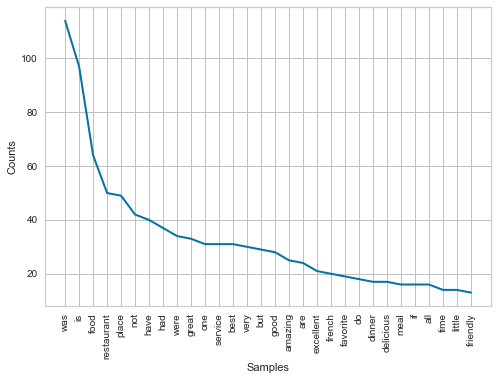

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [233]:
words = nltk.tokenize.word_tokenize(" ".join(reviews["new_text"]))
fdist = nltk.FreqDist(words)
fdist.plot(30)

Nous n'avons plus de mots dit vides. Il nous faut à présent conserver la racine des mots.
Il existe deux méthodes : Stemming et lemmatization.
Stemming supprime les suffixes et les préfixes des mots sans prendre en considération le contexte. 
Contrairement à la méthode stemming, la méthode lemmatization considère le contexte et convertit le mot dans sa forme de base "significative".

In [234]:
reviews

,rw_id,rw_rating,rw_text,nb_words,words,new_words,new_text
0,aGP7nLwEQOUg64jKP8ebsw,5.0,my favorite meal in paris we started off with the foie gras carpaccio and escargot love the uniq...,28.0,"['my', 'favorite', 'meal', 'in', 'paris', 'we', 'started', 'off', 'with', 'the', 'foie', 'gras',...","[favorite, meal, started, foie, gras, carpaccio, escargot, love, unique, way, foie, gras, was, p...",favorite meal started foie gras carpaccio escargot love unique way foie gras was prep...
1,-to6adg_kucf1SgQckgJXw,5.0,this is a small barrestaurant closed to cathdrale notre dame i always come here for lunch or din...,29.0,"['this', 'is', 'a', 'small', 'barrestaurant', 'closed', 'to', 'cathdrale', 'notre', 'dame', 'i',...","[is, small, barrestaurant, closed, cathdrale, notre, dame, always, come, lunch, dinner, if, clos...",is small barrestaurant closed cathdrale notre dame always come lunch dinner if close ...
2,U8G3f8ITSlqBzETBDVO8bw,5.0,foods were delicious great ambiance and helpful staffs the risotto cooked perfectly i got the wh...,24.0,"['foods', 'were', 'delicious', 'great', 'ambiance', 'and', 'helpful', 'staffs', 'the', 'risotto'...","[foods, were, delicious, great, ambiance, helpful, staffs, risotto, cooked, perfectly, got, whit...",foods were delicious great ambiance helpful staffs risotto cooked perfectly got white fish ...
3,WMRKQUUR3BmjV_EZg7zVfw,5.0,this is for a review from this place is perfect would recommend prices are great food is astou...,22.0,"['this', 'is', 'for', 'a', 'review', 'from', 'this', 'place', 'is', 'perfect', 'would', 'recomme...","[is, review, place, is, perfect, would, recommend, prices, are, great, food, is, astoundingand, ...",is review place is perfect would recommend prices are great food is astoundingand never ...
4,giErkj8Al6-egq5XUu2FqA,5.0,michelin starred reservations weeks in advance is absolutely necessary to dine at an establishme...,23.0,"['michelin', 'starred', 'reservations', 'weeks', 'in', 'advance', 'is', 'absolutely', 'necessary...","[michelin, starred, reservations, weeks, advance, is, absolutely, necessary, dine, establishment...",michelin starred reservations weeks advance is absolutely necessary dine establishment like ...
...,...,...,...,...,...,...,...
195,APBAlRXsEX0-B_lwYXFSzw,4.0,paris francehangry when the most popular places are packed au pied du cochon for instance and yo...,26.0,"['paris', 'francehangry', 'when', 'the', 'most', 'popular', 'places', 'are', 'packed', 'au', 'pi...","[francehangry, most, popular, places, are, packed, au, pied, du, cochon, instance, do, not, have...",francehangry most popular places are packed au pied du cochon instance do not have reserv...
196,37Klq0mvBK1WkxnhI0HRCg,5.0,stopped here for dinner on our first night in gai paris we stayed in the the th arrondissements ...,29.0,"['stopped', 'here', 'for', 'dinner', 'on', 'our', 'first', 'night', 'in', 'gai', 'paris', 'we', ...","[stopped, dinner, first, night, gai, stayed, arrondissements, walked, across, seine, satiate]",stopped dinner first night gai stayed arrondissements walked across seine sati...
197,K--hr3q7hJFXuFvZbQTM7Q,5.0,everything on the menu seems to be fully mastered the flavors are amazing at a very affordable p...,28.0,"['everything', 'on', 'the', 'menu', 'seems', 'to', 'be', 'fully', 'mastered', 'the', 'flavors', ...","[everything, menu, seems, be, fully, mastered, flavors, are, amazing, very, affordable, price, h...",everything menu seems be fully mastered flavors are amazing very affordable price highly r...
198,dkkicroZxI_fOiPW4B_GZw,5.0,my husband and i wanted to try a coq au vin while we were in france unfortunately what we did no...,34.0,"['my', 'husband', 'and', 'i', 'wanted', 'to', 'try', 'a', 'coq', 'au', 'vin', 'while', 'we', 'we...","[husband, wanted, try, coq, au, vin, were, france, unfortunately, did, not, know, is, coq, au, v...",husband wanted try coq au vin were france unfortunately did not know is coq au vin is...


Créons une fonction pour utiliser ces méthodes.

In [235]:
def stems(word):
    stemmer = SnowballStemmer(language='english')
    return stemmer.stem(word)
 
def lemmatize_text(text):
    lemmatizer = nltk.stem.WordNetLemmatizer()
    w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
    return lemmatizer.lemmatize(text)

In [236]:
stems("running")

'run'

In [237]:
lemmatize_text("runs")

'run'

In [238]:
def short_words(text, lem_stem, new_var, var_to_convert):
    if lem_stem == 1: 
        stemmer = SnowballStemmer(language='english')
        reviews[new_var] = reviews[var_to_convert].apply(lambda x: " ".join([stemmer.stem(y) for y in x]))
    if lem_stem == 2:
        reviews[new_var] = reviews[var_to_convert].apply(lambda x: " ".join([lemmatize_text(y) for y in x]))

In [239]:
short_words(text, 1, 'stemmed', 'new_words')

In [240]:
short_words(text, 2, 'lemmatized', 'new_words')

In [241]:
reviews

,rw_id,rw_rating,rw_text,nb_words,words,new_words,new_text,stemmed,lemmatized
0,aGP7nLwEQOUg64jKP8ebsw,5.0,my favorite meal in paris we started off with the foie gras carpaccio and escargot love the uniq...,28.0,"['my', 'favorite', 'meal', 'in', 'paris', 'we', 'started', 'off', 'with', 'the', 'foie', 'gras',...","[favorite, meal, started, foie, gras, carpaccio, escargot, love, unique, way, foie, gras, was, p...",favorite meal started foie gras carpaccio escargot love unique way foie gras was prep...,favorit meal start foie gras carpaccio escargot love uniqu way foie gras was prepar thin,favorite meal started foie gras carpaccio escargot love unique way foie gras wa prepared thinly
1,-to6adg_kucf1SgQckgJXw,5.0,this is a small barrestaurant closed to cathdrale notre dame i always come here for lunch or din...,29.0,"['this', 'is', 'a', 'small', 'barrestaurant', 'closed', 'to', 'cathdrale', 'notre', 'dame', 'i',...","[is, small, barrestaurant, closed, cathdrale, notre, dame, always, come, lunch, dinner, if, clos...",is small barrestaurant closed cathdrale notre dame always come lunch dinner if close ...,is small barrestaur close cathdral notr dame alway come lunch dinner if close hostess is veri fr...,is small barrestaurant closed cathdrale notre dame always come lunch dinner if close hostess is ...
2,U8G3f8ITSlqBzETBDVO8bw,5.0,foods were delicious great ambiance and helpful staffs the risotto cooked perfectly i got the wh...,24.0,"['foods', 'were', 'delicious', 'great', 'ambiance', 'and', 'helpful', 'staffs', 'the', 'risotto'...","[foods, were, delicious, great, ambiance, helpful, staffs, risotto, cooked, perfectly, got, whit...",foods were delicious great ambiance helpful staffs risotto cooked perfectly got white fish ...,food were delici great ambianc help staff risotto cook perfect got white fish hous white sauc ta...,food were delicious great ambiance helpful staff risotto cooked perfectly got white fish house w...
3,WMRKQUUR3BmjV_EZg7zVfw,5.0,this is for a review from this place is perfect would recommend prices are great food is astou...,22.0,"['this', 'is', 'for', 'a', 'review', 'from', 'this', 'place', 'is', 'perfect', 'would', 'recomme...","[is, review, place, is, perfect, would, recommend, prices, are, great, food, is, astoundingand, ...",is review place is perfect would recommend prices are great food is astoundingand never ...,is review place is perfect would recommend price are great food is astoundingand never leav review,is review place is perfect would recommend price are great food is astoundingand never leave review
4,giErkj8Al6-egq5XUu2FqA,5.0,michelin starred reservations weeks in advance is absolutely necessary to dine at an establishme...,23.0,"['michelin', 'starred', 'reservations', 'weeks', 'in', 'advance', 'is', 'absolutely', 'necessary...","[michelin, starred, reservations, weeks, advance, is, absolutely, necessary, dine, establishment...",michelin starred reservations weeks advance is absolutely necessary dine establishment like ...,michelin star reserv week advanc is absolut necessari dine establish like second time veri sophi...,michelin starred reservation week advance is absolutely necessary dine establishment like second...
...,...,...,...,...,...,...,...,...,...
195,APBAlRXsEX0-B_lwYXFSzw,4.0,paris francehangry when the most popular places are packed au pied du cochon for instance and yo...,26.0,"['paris', 'francehangry', 'when', 'the', 'most', 'popular', 'places', 'are', 'packed', 'au', 'pi...","[francehangry, most, popular, places, are, packed, au, pied, du, cochon, instance, do, not, have...",francehangry most popular places are packed au pied du cochon instance do not have reserv...,francehangri most popular place are pack au pie du cochon instanc do not have reserv littl corne...,francehangry most popular place are packed au pied du cochon instance do not have reservation li...
196,37Klq0mvBK1WkxnhI0HRCg,5.0,stopped here for dinner on our first night in gai paris we stayed in the the th arron

Regardons les mots les plus fréquents pour ces deux colonnes

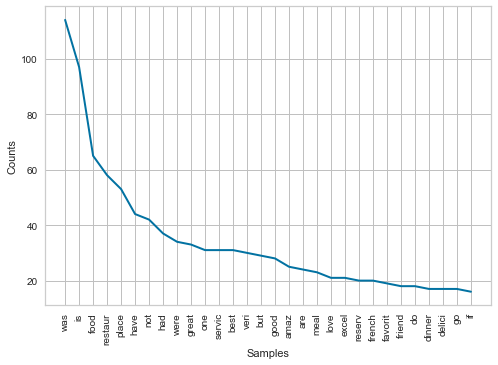

In [242]:
nb_most_frequent_plt(reviews["stemmed"])

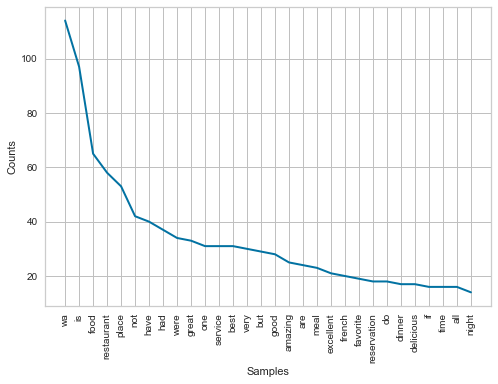

In [243]:
nb_most_frequent_plt(reviews["lemmatized"])

In [244]:
reviews.head(2)

,rw_id,rw_rating,rw_text,nb_words,words,new_words,new_text,stemmed,lemmatized
0,aGP7nLwEQOUg64jKP8ebsw,5.0,my favorite meal in paris we started off with the foie gras carpaccio and escargot love the uniq...,28.0,"['my', 'favorite', 'meal', 'in', 'paris', 'we', 'started', 'off', 'with', 'the', 'foie', 'gras',...","[favorite, meal, started, foie, gras, carpaccio, escargot, love, unique, way, foie, gras, was, p...",favorite meal started foie gras carpaccio escargot love unique way foie gras was prep...,favorit meal start foie gras carpaccio escargot love uniqu way foie gras was prepar thin,favorite meal started foie gras carpaccio escargot love unique way foie gras wa prepared thinly
1,-to6adg_kucf1SgQckgJXw,5.0,this is a small barrestaurant closed to cathdrale notre dame i always come here for lunch or din...,29.0,"['this', 'is', 'a', 'small', 'barrestaurant', 'closed', 'to', 'cathdrale', 'notre', 'dame', 'i',...","[is, small, barrestaurant, closed, cathdrale, notre, dame, always, come, lunch, dinner, if, clos...",is small barrestaurant closed cathdrale notre dame always come lunch dinner if close ...,is small barrestaur close cathdral notr dame alway come lunch dinner if close hostess is veri fr...,is small barrestaurant closed cathdrale notre dame always come lunch dinner if close hostess is ...


In [245]:
trigrams_all= []
for element in reviews["words_ok"]:
    token = nltk.word_tokenize(element)
    trigrams = ngrams(token,3)
    trigrams_all.append(list(trigrams))
    break
trigrams_all

KeyError: 'words_ok'

In [ ]:
gc.collect()

0

In [246]:
reviews.head(2)

,rw_id,rw_rating,rw_text,nb_words,words,new_words,new_text,stemmed,lemmatized
0,aGP7nLwEQOUg64jKP8ebsw,5.0,my favorite meal in paris we started off with the foie gras carpaccio and escargot love the uniq...,28.0,"['my', 'favorite', 'meal', 'in', 'paris', 'we', 'started', 'off', 'with', 'the', 'foie', 'gras',...","[favorite, meal, started, foie, gras, carpaccio, escargot, love, unique, way, foie, gras, was, p...",favorite meal started foie gras carpaccio escargot love unique way foie gras was prep...,favorit meal start foie gras carpaccio escargot love uniqu way foie gras was prepar thin,favorite meal started foie gras carpaccio escargot love unique way foie gras wa prepared thinly
1,-to6adg_kucf1SgQckgJXw,5.0,this is a small barrestaurant closed to cathdrale notre dame i always come here for lunch or din...,29.0,"['this', 'is', 'a', 'small', 'barrestaurant', 'closed', 'to', 'cathdrale', 'notre', 'dame', 'i',...","[is, small, barrestaurant, closed, cathdrale, notre, dame, always, come, lunch, dinner, if, clos...",is small barrestaurant closed cathdrale notre dame always come lunch dinner if close ...,is small barrestaur close cathdral notr dame alway come lunch dinner if close hostess is veri fr...,is small barrestaurant closed cathdrale notre dame always come lunch dinner if close hostess is ...


nous pouvons supprimer les colonnes inutiles

In [247]:
del reviews["nb_words"]

In [248]:
reviews = reviews.drop(["new_words", "words"], axis=1)

In [249]:
reviews.head(2)

,rw_id,rw_rating,rw_text,new_text,stemmed,lemmatized
0,aGP7nLwEQOUg64jKP8ebsw,5.0,my favorite meal in paris we started off with the foie gras carpaccio and escargot love the uniq...,favorite meal started foie gras carpaccio escargot love unique way foie gras was prep...,favorit meal start foie gras carpaccio escargot love uniqu way foie gras was prepar thin,favorite meal started foie gras carpaccio escargot love unique way foie gras wa prepared thinly
1,-to6adg_kucf1SgQckgJXw,5.0,this is a small barrestaurant closed to cathdrale notre dame i always come here for lunch or din...,is small barrestaurant closed cathdrale notre dame always come lunch dinner if close ...,is small barrestaur close cathdral notr dame alway come lunch dinner if close hostess is veri fr...,is small barrestaurant closed cathdrale notre dame always come lunch dinner if close hostess is ...


Ajoutons des tags pour connaitre la nature de chaque mot.

In [250]:
nltk.word_tokenize("toto est dans ")

['toto', 'est', 'dans']

In [251]:
def word_pos_tagger(list_words):
    pos_tagged_text = nltk.pos_tag(list_words)
    return pos_tagged_text

In [252]:
all_reviews = reviews["new_text"].str.cat(sep=' ')

In [253]:
description_words = word_pos_tagger(nltk.word_tokenize(all_reviews))

In [254]:
description_words

[('favorite', 'JJ'),
 ('meal', 'NN'),
 ('started', 'VBD'),
 ('foie', 'JJ'),
 ('gras', 'NNS'),
 ('carpaccio', 'VBP'),
 ('escargot', 'RB'),
 ('love', 'VB'),
 ('unique', 'JJ'),
 ('way', 'NN'),
 ('foie', 'NN'),
 ('gras', 'NN'),
 ('was', 'VBD'),
 ('prepared', 'VBN'),
 ('thinly', 'RB'),
 ('is', 'VBZ'),
 ('small', 'JJ'),
 ('barrestaurant', 'NN'),
 ('closed', 'VBD'),
 ('cathdrale', 'NN'),
 ('notre', 'NN'),
 ('dame', 'NN'),
 ('always', 'RB'),
 ('come', 'VBN'),
 ('lunch', 'NN'),
 ('dinner', 'NN'),
 ('if', 'IN'),
 ('close', 'JJ'),
 ('hostess', 'NN'),
 ('is', 'VBZ'),
 ('very', 'RB'),
 ('friendly', 'JJ'),
 ('foods', 'NNS'),
 ('were', 'VBD'),
 ('delicious', 'JJ'),
 ('great', 'JJ'),
 ('ambiance', 'NN'),
 ('helpful', 'JJ'),
 ('staffs', 'NNS'),
 ('risotto', 'VBP'),
 ('cooked', 'VBN'),
 ('perfectly', 'RB'),
 ('got', 'VBD'),
 ('white', 'JJ'),
 ('fish', 'JJ'),
 ('house', 'NN'),
 ('white', 'JJ'),
 ('sauce', 'NN'),
 ('tasta', 'NN'),
 ('like', 'IN'),
 ('fennel', 'NN'),
 ('is', 'VBZ'),
 ('review', 'JJ'),
 ('p

In [255]:
tag_fd = nltk.FreqDist(tag for (word, tag) in description_words)

In [256]:
list_keep = []
list_excl = ['IN', 'DT', 'CD', 'CC', 'RP', 'WDT', 'EX']
for word, tag in description_words:
    if tag not in list_excl:
        list_keep.append(tag)

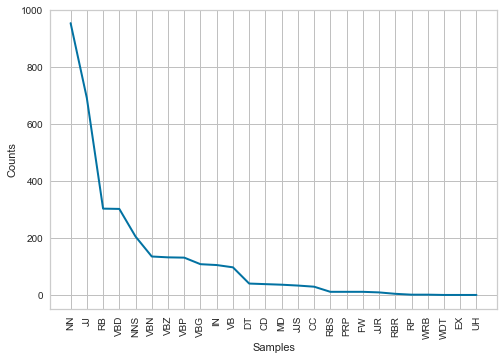

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [257]:
tag_fd.plot()

UH = interjection (expression affective > ha, oh)
EX = existentiel (ex : il y a)
WDT = wh-déterminant (ex : qui)
pour plus d'informations, voir : https://www.learntek.org/blog/categorizing-pos-tagging-nltk-python/

On exclut : IN, DT, CD, CC, RP, WDT, EX


In [258]:
reviews.head(2)

,rw_id,rw_rating,rw_text,new_text,stemmed,lemmatized
0,aGP7nLwEQOUg64jKP8ebsw,5.0,my favorite meal in paris we started off with the foie gras carpaccio and escargot love the uniq...,favorite meal started foie gras carpaccio escargot love unique way foie gras was prep...,favorit meal start foie gras carpaccio escargot love uniqu way foie gras was prepar thin,favorite meal started foie gras carpaccio escargot love unique way foie gras wa prepared thinly
1,-to6adg_kucf1SgQckgJXw,5.0,this is a small barrestaurant closed to cathdrale notre dame i always come here for lunch or din...,is small barrestaurant closed cathdrale notre dame always come lunch dinner if close ...,is small barrestaur close cathdral notr dame alway come lunch dinner if close hostess is veri fr...,is small barrestaurant closed cathdrale notre dame always come lunch dinner if close hostess is ...


In [259]:
reviews["text_tokens_pos_tagged"] =  reviews["new_text"].apply(lambda x: " ".join([y for y, tag in word_pos_tagger(nltk.word_tokenize(x)) if tag in list_keep]))

In [260]:
list_nouns = ["NN", "NNS", "NNP", "NNPS"]
reviews["words_subjects"] =  reviews["new_text"].apply(lambda x: " ".join([y for y, tag in word_pos_tagger(nltk.word_tokenize(x)) if tag in list_nouns]))
reviews["words_subjects_st"] =  reviews["stemmed"].apply(lambda x: " ".join([y for y, tag in word_pos_tagger(nltk.word_tokenize(x)) if tag in list_nouns]))
reviews["words_subjects_lem"] =  reviews["lemmatized"].apply(lambda x: " ".join([y for y, tag in word_pos_tagger(nltk.word_tokenize(x)) if tag in list_nouns]))

In [261]:
reviews.head(2)

,rw_id,rw_rating,rw_text,new_text,stemmed,lemmatized,text_tokens_pos_tagged,words_subjects,words_subjects_st,words_subjects_lem
0,aGP7nLwEQOUg64jKP8ebsw,5.0,my favorite meal in paris we started off with the foie gras carpaccio and escargot love the uniq...,favorite meal started foie gras carpaccio escargot love unique way foie gras was prep...,favorit meal start foie gras carpaccio escargot love uniqu way foie gras was prepar thin,favorite meal started foie gras carpaccio escargot love unique way foie gras wa prepared thinly,favorite meal started foie gras carpaccio escargot love unique way foie gras was prepared thinly,meal gras way foie gras,favorit start foie gras way foie gras,meal gras way gras
1,-to6adg_kucf1SgQckgJXw,5.0,this is a small barrestaurant closed to cathdrale notre dame i always come here for lunch or din...,is small barrestaurant closed cathdrale notre dame always come lunch dinner if close ...,is small barrestaur close cathdral notr dame alway come lunch dinner if close hostess is veri fr...,is small barrestaurant closed cathdrale notre dame always come lunch dinner if close hostess is ...,is small barrestaurant closed cathdrale notre dame always come lunch dinner close hostess is ver...,barrestaurant cathdrale notre dame lunch dinner hostess,barrestaur notr dame lunch dinner hostess friend,barrestaurant cathdrale notre dame lunch dinner hostess


Nous utilisons Vader pour obtenir les impressions de sentiments des couples de mots(positif, neutre, negatif).

Créons une fonction pour obtenir des informations sur les sentiments des groupes de mots.

In [262]:
# import SentimentIntensityAnalyzer class
# from vaderSentiment.vaderSentiment module.
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
 
# function to print sentiments
# of the sentence.
def sentiment_scores(sentence):
 
    # Create a SentimentIntensityAnalyzer object.
    sid_obj = SentimentIntensityAnalyzer()
 
    # polarity_scores method of SentimentIntensityAnalyzer
    # object gives a sentiment dictionary.
    # which contains pos, neg, neu, and compound scores.
    sentiment_dict = sid_obj.polarity_scores(sentence)
    
    return sentiment_dict

In [263]:
for idx, review in reviews.iterrows():

    # pour les sentiments, on regarde le texte en entier car il nous faut les adjectifs
    res_sentiments = sentiment_scores(review["text_tokens_pos_tagged"])
    
    # decide sentiment as positive, negative and neutral
    if res_sentiments['compound'] >= 0.6 and res_sentiments['pos']>0.5 :
        feeling_avg = "Positive"
    elif res_sentiments['compound'] <= - 0.5  and res_sentiments['neg'] > 0.3 :
        feeling_avg = "Negative"
    else :
        feeling_avg = "Neutral"

    reviews.loc[idx, "feeling_neg"] = res_sentiments['neg']
    reviews.loc[idx, "feeling_neu"] = res_sentiments['neu']
    reviews.loc[idx, "compound"] = res_sentiments['compound']
    reviews.loc[idx, "feeling_pos"] = res_sentiments['pos']
    reviews.loc[idx, "feeling_avg"] = feeling_avg

In [264]:
reviews.head(2)

,rw_id,rw_rating,rw_text,new_text,stemmed,lemmatized,text_tokens_pos_tagged,words_subjects,words_subjects_st,words_subjects_lem,feeling_neg,feeling_neu,compound,feeling_pos,feeling_avg
0,aGP7nLwEQOUg64jKP8ebsw,5.0,my favorite meal in paris we started off with the foie gras carpaccio and escargot love the uniq...,favorite meal started foie gras carpaccio escargot love unique way foie gras was prep...,favorit meal start foie gras carpaccio escargot love uniqu way foie gras was prepar thin,favorite meal started foie gras carpaccio escargot love unique way foie gras wa prepared thinly,favorite meal started foie gras carpaccio escargot love unique way foie gras was prepared thinly,meal gras way foie gras,favorit start foie gras way foie gras,meal gras way gras,0.0,0.569,0.8442,0.431,Neutral
1,-to6adg_kucf1SgQckgJXw,5.0,this is a small barrestaurant closed to cathdrale notre dame i always come here for lunch or din...,is small barrestaurant closed cathdrale notre dame always come lunch dinner if close ...,is small barrestaur close cathdral notr dame alway come lunch dinner if close hostess is veri fr...,is small barrestaurant closed cathdrale notre dame always come lunch dinner if close hostess is ...,is small barrestaurant closed cathdrale notre dame always come lunch dinner close hostess is ver...,barrestaurant cathdrale notre dame lunch dinner hostess,barrestaur notr dame lunch dinner hostess friend,barrestaurant cathdrale notre dame lunch dinner hostess,0.0,0.811,0.5413,0.189,Neutral


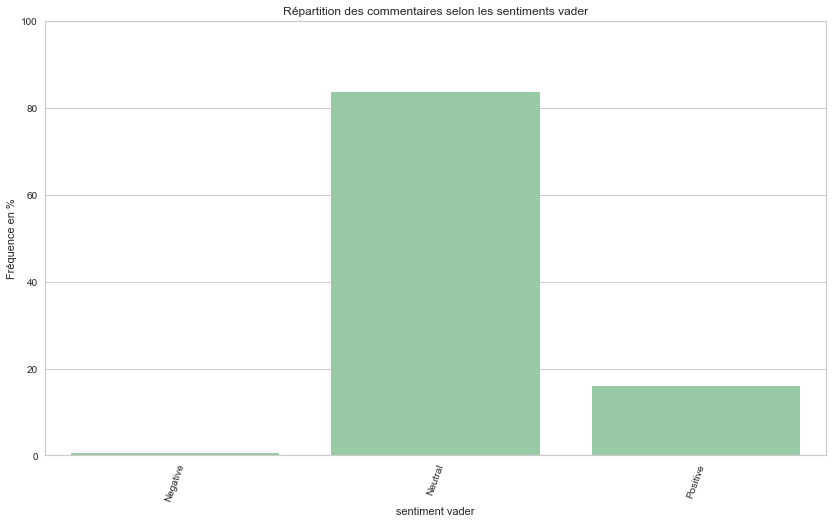

In [265]:
pk.graph_barplot(reviews['feeling_avg'],
                  "Répartition des commentaires selon les sentiments vader",
                  (0.564, 0.823, 0.631),
                   0, 100, "sentiment vader", "Fréquence en %",70, 1, (14,8))

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\seaborn\categorical.py:381: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

D:\Users\Aurel\Anaconda3\envs\venv_006\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



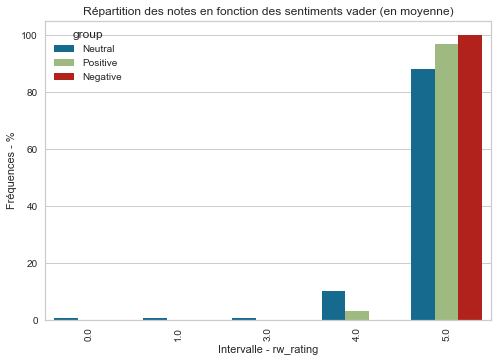

In [266]:
pk.graph_barplot_by_group(reviews, 'rw_rating', 'feeling_avg', '#6D8260', 'Répartition des notes en fonction des sentiments vader (en moyenne)')


In [267]:
for i in reviews.loc[reviews["feeling_avg"]=='Negative']["rw_text"].head(10):
    print(i)

michelin one thing ill always carry with me when i think back on my trip to paris was not only the food because its amazing but the smell of the


In [268]:
for idx, i in reviews.loc[reviews["rw_rating"]==5].head(10).iterrows():
    print(i["rw_text"], " ", str(i["compound"]))

my favorite meal in paris we started off with the foie gras carpaccio and escargot love the unique way that the foie gras was prepared and so thinly   0.8442
this is a small barrestaurant closed to cathdrale notre dame i always come here for lunch or dinner if i am close by the hostess is very friendly the   0.5413
foods were delicious great ambiance and helpful staffs the risotto cooked perfectly i got the white fish with house white sauce tasta like fennel   0.9413
this is for a review from  this place is perfect would recommend  prices are great food is astoundingand i never leave reviews   0.8872
michelin starred reservations weeks in advance is absolutely necessary to dine at an establishment like this my second time here very sophisticated vibe   0.5984
when i visited paris last week i had stopped by here by a recommendation of a friend and also recommended by bourdain this place was amazing and lives up   0.7845
based on some research we decided to book a reservation here for a 

Nous conservons les reviews inférieur ou égal à 5.

In [269]:
reviews_sav = reviews.copy()

In [270]:
reviews = reviews_sav.loc[reviews_sav["rw_rating"]<5].copy()

In [271]:
reviews.describe()

,rw_rating,feeling_neg,feeling_neu,compound,feeling_pos
count,21.000000,21.000000,21.000000,21.000000,21.000000
mean,3.619048,0.022524,0.637429,0.611495,0.292381
std,1.071270,0.038499,0.225536,0.314978,0.168617
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,0.000000,0.527000,0.475400,0.162000
50%,4.000000,0.000000,0.632000,0.750600,0.297000
75%,4.000000,0.047000,0.769000,0.859100,0.436000
max,4.000000,0.117000,1.000000,0.923000,0.564000


Regardons les sujets qui ressortent à l'aide d'un graphique word cloud

In [272]:
from wordcloud import WordCloud
from PIL import Image

In [273]:
reviews.head(2)

,rw_id,rw_rating,rw_text,new_text,stemmed,lemmatized,text_tokens_pos_tagged,words_subjects,words_subjects_st,words_subjects_lem,feeling_neg,feeling_neu,compound,feeling_pos,feeling_avg
22,e970XRRbYSDC83PEADB1gw,4.0,boo boo and i came here after a few hours at the louvre museum there was a long wait but it move...,boo boo came after few hours louvre museum was long wait but moved fast staff setup ...,boo boo came after few hour louvr museum was long wait but move fast staff setup make dine just,boo boo came after few hour louvre museum wa long wait but moved fast staff setup make dining just,boo boo came few hours louvre museum was long wait moved fast staff setup makes dining just,boo boo hours museum wait staff setup,boo boo hour louvr museum wait staff setup dine,boo boo hour louvre museum wa wait staff setup dining,0.000,1.000,0.000,0.000,Neutral
31,WZgU_NdPlyXWHBuQi3LEPA,4.0,very good restaurant for french cuisine thanks to the reviewers before me leave a good guidance ...,very good restaurant french cuisine thanks reviewers before leave good guidance definitely ...,veri good restaur french cuisin thank review befor leav good guidanc definit accur true call res...,very good restaurant french cuisine thanks reviewer before leave good guidance definitely accura...,very good restaurant french cuisine thanks reviewers leave good guidance definitely accurate tru...,restaurant cuisine thanks reviewers guidance call restaurant,restaur cuisin thank review guidanc definit call restaur,restaurant cuisine thanks guidance call restaurant,0.047,0.389,0.923,0.564,Positive


In [274]:
all_reviews = reviews["words_subjects"].str.cat(sep=' ')

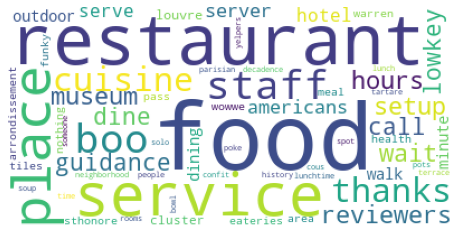

In [275]:
wordcloud = WordCloud(background_color = 'white', max_words = 60).generate(all_reviews)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

Nous remarquons que les sujets principaux sont le repas, le service, le restaurant, la localisation et le menu.

In [276]:
def wordcloud_plot(data):
    all_reviews = data.str.cat(sep=' ')
    wordcloud = WordCloud(background_color = 'white', max_words = 60).generate(all_reviews)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

In [277]:
reviews.columns

Index(['rw_id', 'rw_rating', 'rw_text', 'new_text', 'stemmed', 'lemmatized',
       'text_tokens_pos_tagged', 'words_subjects', 'words_subjects_st',
       'words_subjects_lem', 'feeling_neg', 'feeling_neu', 'compound',
       'feeling_pos', 'feeling_avg'],
      dtype='object')

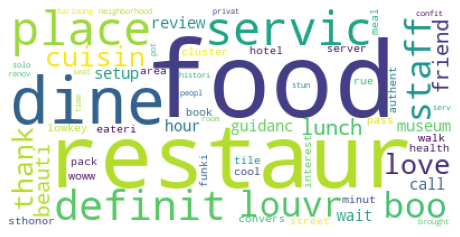

In [278]:
wordcloud_plot(reviews["words_subjects_st"])

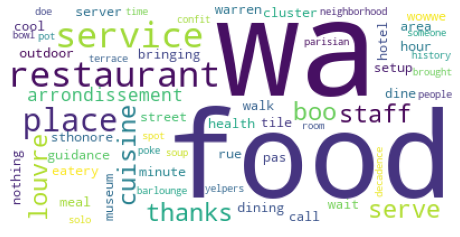

In [279]:
wordcloud_plot(reviews["words_subjects_lem"])

La colonne words_subjects semble donner de meilleurs résultats

<>:1: DeprecationWarning:

invalid escape sequence \c

<>:1: DeprecationWarning:

invalid escape sequence \c

C:\Users\aurel\AppData\Local\Temp\ipykernel_8832\3489269837.py:1: DeprecationWarning:

invalid escape sequence \c



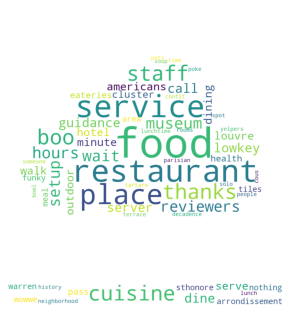

In [280]:
mask = np.array(Image.open("input\cloud.jpg"))
mask[mask == 1] = 255

wordcloud = WordCloud(background_color = "white", max_words = 60, mask = mask).generate(all_reviews)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## Features : deux méthodes BOW & TF-IDF

### BOW

le modèle CBOW prédit le mot actuel en fonction des mots du contexte dans une fenêtre spécifique:
- La couche d'entrée contient les mots de contexte
- la couche de sortie contient le mot courant
- la couche cachée contient le nombre de dimensions dans lesquelles nous voulons représenter le mot actuel présent à la couche de sortie.

In [281]:
reviews.head(5)

,rw_id,rw_rating,rw_text,new_text,stemmed,lemmatized,text_tokens_pos_tagged,words_subjects,words_subjects_st,words_subjects_lem,feeling_neg,feeling_neu,compound,feeling_pos,feeling_avg
22,e970XRRbYSDC83PEADB1gw,4.0,boo boo and i came here after a few hours at the louvre museum there was a long wait but it move...,boo boo came after few hours louvre museum was long wait but moved fast staff setup ...,boo boo came after few hour louvr museum was long wait but move fast staff setup make dine just,boo boo came after few hour louvre museum wa long wait but moved fast staff setup make dining just,boo boo came few hours louvre museum was long wait moved fast staff setup makes dining just,boo boo hours museum wait staff setup,boo boo hour louvr museum wait staff setup dine,boo boo hour louvre museum wa wait staff setup dining,0.000,1.000,0.0000,0.000,Neutral
31,WZgU_NdPlyXWHBuQi3LEPA,4.0,very good restaurant for french cuisine thanks to the reviewers before me leave a good guidance ...,very good restaurant french cuisine thanks reviewers before leave good guidance definitely ...,veri good restaur french cuisin thank review befor leav good guidanc definit accur true call res...,very good restaurant french cuisine thanks reviewer before leave good guidance definitely accura...,very good restaurant french cuisine thanks reviewers leave good guidance definitely accurate tru...,restaurant cuisine thanks reviewers guidance call restaurant,restaur cuisin thank review guidanc definit call restaur,restaurant cuisine thanks guidance call restaurant,0.047,0.389,0.9230,0.564,Positive
33,9zPoJDR7H1s0P0SeexSIwg,4.0,casual and lowkey place it was very relaxing to dine here the server was keen on recognizing us ...,casual lowkey place was very relaxing dine server was keen recognizing us americans conv...,casual lowkey place was veri relax dine server was keen recogn us american convers us bring,casual lowkey place wa very relaxing dine server wa keen recognizing u american conversed u brin...,casual lowkey place was very relaxing dine server was keen recognizing us americans conversed us...,lowkey place dine server americans,lowkey place dine server convers,place dine server bringing,0.000,0.625,0.7778,0.375,Neutral
43,hiVILjoj4qcKApkY0q9CHw,4.0,the hostess from my hotel recommended this place as they serve authentic french cuisine came to...,hostess hotel recommended place serve authentic french cuisine came restaurant outdoor...,hostess hotel recommend place serv authent french cuisin came restaur outdoor dine was pack,hostess hotel recommended place serve authentic french cuisine came restaurant outdoor dining wa...,hostess hotel recommended place serve authentic french cuisine came restaurant outdoor dining wa...,hotel place serve cuisine outdoor dining,hotel place authent cuisin dine pack,hotel place serve cuisine outdoor wa,0.000,0.878,0.2023,0.122,Neutral
45,NaN,0.0,,,,,,,,,0.000,0.000,0.0000,0.000,Neutral


In [282]:
reviews = reviews.reset_index()

In [283]:
from  sklearn.feature_extraction.text  import CountVectorizer 
# créer un vecteur d'objet 
vectorizer = CountVectorizer()
corpus = reviews["words_subjects"]


In [284]:
# apprendre le vocabulaire et stocker la matrice creuse CountVectorizer dans X 
cbow = vectorizer.fit_transform(corpus).todense()
new_cols = vectorizer.get_feature_names()

In [285]:
# join the tfidf values to the existing dataframe
reviews = reviews.join(pd.DataFrame(cbow, columns=new_cols))

In [286]:
reviews.head(2)

,index,rw_id,rw_rating,rw_text,new_text,stemmed,lemmatized,text_tokens_pos_tagged,words_subjects,words_subjects_st,...,tearsofhappinesswe,terrace,thanks,tiles,time,wait,walk,warren,wowwe,yelpers
0,22,e970XRRbYSDC83PEADB1gw,4.0,boo boo and i came here after a few hours at the louvre museum there was a long wait but it move...,boo boo came after few hours louvre museum was long wait but moved fast staff setup ...,boo boo came after few hour louvr museum was long wait but move fast staff setup make dine just,boo boo came after few hour louvre museum wa long wait but moved fast staff setup make dining just,boo boo came few hours louvre museum was long wait moved fast staff setup makes dining just,boo boo hours museum wait staff setup,boo boo hour louvr museum wait staff setup dine,...,0,0,0,0,0,1,0,0,0,0
1,31,WZgU_NdPlyXWHBuQi3LEPA,4.0,very good restaurant for french cuisine thanks to the reviewers before me leave a good guidance ...,very good restaurant french cuisine thanks reviewers before leave good guidance definitely ...,veri good restaur french cuisin thank review befor leav good guidanc definit accur true call res...,very good restaurant french cuisine thanks reviewer before leave good guidance definitely accura...,very good restaurant french cuisine thanks reviewers leave good guidance definitely accurate tru...,restaurant cuisine thanks reviewers guidance call restaurant,restaur cuisin thank review guidanc definit call restaur,...,0,0,1,0,0,0,0,0,0,0


### TF-IDF

Matrice avec les noms pour trouver les themes abordés dans le corpus. Puis après, refaire une matrice avec theme + word_ok pour avoir les sentiments sur les themes.

In [287]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfIdfVectorizer=TfidfVectorizer(use_idf=True)
tfIdf = tfIdfVectorizer.fit_transform(reviews["words_subjects"]).todense()
new_cols = vectorizer.get_feature_names()


In [288]:
tfidf_df = pd.DataFrame(tfIdf, columns=new_cols)

In [289]:
tfidf_df

,americans,appetizers,area,arrondissement,bit,boo,bowl,cafe,call,cluster,...,tearsofhappinesswe,terrace,thanks,tiles,time,wait,walk,warren,wowwe,yelpers
0,0.000000,0.000000,0.000000,0.00000,0.000000,0.675137,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.337569,0.000000,0.00000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.386775,0.000000,...,0.000000,0.000000,0.340622,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
2,0.464557,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.364338,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.364338,0.00000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.57735,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.57735,0.000000,0.000000
7,0.000000,0.000000,0.408248,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.408248,0.000000,0.000000,0.000000,0.00000,0.408248,0.000000
8,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000


In [290]:
reviews.head(2)

,index,rw_id,rw_rating,rw_text,new_text,stemmed,lemmatized,text_tokens_pos_tagged,words_subjects,words_subjects_st,...,tearsofhappinesswe,terrace,thanks,tiles,time,wait,walk,warren,wowwe,yelpers
0,22,e970XRRbYSDC83PEADB1gw,4.0,boo boo and i came here after a few hours at the louvre museum there was a long wait but it move...,boo boo came after few hours louvre museum was long wait but moved fast staff setup ...,boo boo came after few hour louvr museum was long wait but move fast staff setup make dine just,boo boo came after few hour louvre museum wa long wait but moved fast staff setup make dining just,boo boo came few hours louvre museum was long wait moved fast staff setup makes dining just,boo boo hours museum wait staff setup,boo boo hour louvr museum wait staff setup dine,...,0,0,0,0,0,1,0,0,0,0
1,31,WZgU_NdPlyXWHBuQi3LEPA,4.0,very good restaurant for french cuisine thanks to the reviewers before me leave a good guidance ...,very good restaurant french cuisine thanks reviewers before leave good guidance definitely ...,veri good restaur french cuisin thank review befor leav good guidanc definit accur true call res...,very good restaurant french cuisine thanks reviewer before leave good guidance definitely accura...,very good restaurant french cuisine thanks reviewers leave good guidance definitely accurate tru...,restaurant cuisine thanks reviewers guidance call restaurant,restaur cuisin thank review guidanc definit call restaur,...,0,0,1,0,0,0,0,0,0,0


In [291]:
# join the tfidf values to the existing dataframe
reviews = reviews.join(tfidf_df, rsuffix='_tfidf')

In [292]:
reviews

,index,rw_id,rw_rating,rw_text,new_text,stemmed,lemmatized,text_tokens_pos_tagged,words_subjects,words_subjects_st,...,tearsofhappinesswe_tfidf,terrace_tfidf,thanks_tfidf,tiles_tfidf,time_tfidf,wait_tfidf,walk_tfidf,warren_tfidf,wowwe_tfidf,yelpers_tfidf
0,22,e970XRRbYSDC83PEADB1gw,4.0,boo boo and i came here after a few hours at the louvre museum there was a long wait but it move...,boo boo came after few hours louvre museum was long wait but moved fast staff setup ...,boo boo came after few hour louvr museum was long wait but move fast staff setup make dine just,boo boo came after few hour louvre museum wa long wait but moved fast staff setup make dining just,boo boo came few hours louvre museum was long wait moved fast staff setup makes dining just,boo boo hours museum wait staff setup,boo boo hour louvr museum wait staff setup dine,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.337569,0.000000,0.00000,0.000000,0.000000
1,31,WZgU_NdPlyXWHBuQi3LEPA,4.0,very good restaurant for french cuisine thanks to the reviewers before me leave a good guidance ...,very good restaurant french cuisine thanks reviewers before leave good guidance definitely ...,veri good restaur french cuisin thank review befor leav good guidanc definit accur true call res...,very good restaurant french cuisine thanks reviewer before leave good guidance definitely accura...,very good restaurant french cuisine thanks reviewers leave good guidance definitely accurate tru...,restaurant cuisine thanks reviewers guidance call restaurant,restaur cuisin thank review guidanc definit call restaur,...,0.000000,0.000000,0.340622,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
2,33,9zPoJDR7H1s0P0SeexSIwg,4.0,casual and lowkey place it was very relaxing to dine here the server was keen on recognizing us ...,casual lowkey place was very relaxing dine server was keen recognizing us americans conv...,casual lowkey place was veri relax dine server was keen recogn us american convers us bring,casual lowkey place wa very relaxing dine server wa keen recognizing u american conversed u brin...,casual lowkey place was very relaxing dine server was keen recognizing us americans conversed us...,lowkey place dine server americans,lowkey place dine server convers,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
3,43,hiVILjoj4qcKApkY0q9CHw,4.0,the hostess from my hotel recommended this place as they serve authentic french cuisine came to...,hostess hotel recommended place serve authentic french cuisine came restaurant outdoor...,hostess hotel recommend place serv authent french cuisin came restaur outdoor dine was pack,hostess hotel recommended place serve authentic french cuisine came restaurant outdoor dining wa...,hostess hotel recommended place serve authentic french cuisine came restaurant outdoor dining wa...,hotel place serve cuisine outdoor dining,hotel place authent cuisin dine pack,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
4,45,NaN,0.0,,,,,,,,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
5,62,6VRDbCMuGKSxcYiNx6Sg4g,4.0,a five minute walk from the louvre this restaurant was among a cluster of other eateries they a...,five minute walk louvre restaurant was among cluster other eateries also checked health...,five minut walk louvr restaur was among cluster other eateri also check health pass like was,five minute walk louvre restaurant wa among cluster other eatery also checked health pas like wa,minute walk louvre restaurant was cluster other eateries also checked health pass was,minute walk louvre restaurant cluster eateries health pass,minut walk louvr restaur cluster eateri health pass,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.364338,0.00000,0.000000,0.000000
6,103,95kmdLo02hNYlWoXFIkrTA,4.0,great restaurant in the er arrondissement down in a warren of streets off the rue sthonore i had...,great restau

Maintenant que nous avons ajouté nos features, nous pouvons réaliser une PCA afin de voir quelles sont les variables qui expliquent au mieux nos données.

# Analyse multidimensionnelle : ACP / T-SNE / UMAP

ajouts infos des methodes

In [293]:
del reviews["index"]

In [294]:
df_acp = reviews.copy()


In [295]:
df_acp.head(2)

,rw_id,rw_rating,rw_text,new_text,stemmed,lemmatized,text_tokens_pos_tagged,words_subjects,words_subjects_st,words_subjects_lem,...,tearsofhappinesswe_tfidf,terrace_tfidf,thanks_tfidf,tiles_tfidf,time_tfidf,wait_tfidf,walk_tfidf,warren_tfidf,wowwe_tfidf,yelpers_tfidf
0,e970XRRbYSDC83PEADB1gw,4.0,boo boo and i came here after a few hours at the louvre museum there was a long wait but it move...,boo boo came after few hours louvre museum was long wait but moved fast staff setup ...,boo boo came after few hour louvr museum was long wait but move fast staff setup make dine just,boo boo came after few hour louvre museum wa long wait but moved fast staff setup make dining just,boo boo came few hours louvre museum was long wait moved fast staff setup makes dining just,boo boo hours museum wait staff setup,boo boo hour louvr museum wait staff setup dine,boo boo hour louvre museum wa wait staff setup dining,...,0.0,0.0,0.000000,0.0,0.0,0.337569,0.0,0.0,0.0,0.0
1,WZgU_NdPlyXWHBuQi3LEPA,4.0,very good restaurant for french cuisine thanks to the reviewers before me leave a good guidance ...,very good restaurant french cuisine thanks reviewers before leave good guidance definitely ...,veri good restaur french cuisin thank review befor leav good guidanc definit accur true call res...,very good restaurant french cuisine thanks reviewer before leave good guidance definitely accura...,very good restaurant french cuisine thanks reviewers leave good guidance definitely accurate tru...,restaurant cuisine thanks reviewers guidance call restaurant,restaur cuisin thank review guidanc definit call restaur,restaurant cuisine thanks guidance call restaurant,...,0.0,0.0,0.340622,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [301]:
df_acp2 = df_acp.drop(["rw_id", "rw_rating", "rw_text", "new_text", "stemmed", "lemmatized", "text_tokens_pos_tagged", "feeling_avg", "words_subjects"], axis=1)

In [303]:
del df_acp2["words_subjects_st"]
del df_acp2["words_subjects_lem"]

In [304]:
df_acp2.head(2)

,feeling_neg,feeling_neu,compound,feeling_pos,americans,appetizers,area,arrondissement,bit,boo,...,tearsofhappinesswe_tfidf,terrace_tfidf,thanks_tfidf,tiles_tfidf,time_tfidf,wait_tfidf,walk_tfidf,warren_tfidf,wowwe_tfidf,yelpers_tfidf
0,0.000,1.000,0.000,0.000,0,0,0,0,0,2,...,0.0,0.0,0.000000,0.0,0.0,0.337569,0.0,0.0,0.0,0.0
1,0.047,0.389,0.923,0.564,0,0,0,0,0,0,...,0.0,0.0,0.340622,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


### ACP

21
[1.62836347e+01 1.55485389e+01 1.45269394e+01 1.37088017e+01
 1.34728971e+01 1.31317090e+01 1.29420720e+01 1.19491807e+01
 1.01997719e+01 9.89901726e+00 9.33609401e+00 8.57899087e+00
 7.23492118e+00 7.06155793e+00 6.92153025e+00 6.02963146e+00
 4.78512266e+00 3.43846989e+00 2.62243013e+00 1.32868903e+00
 1.04023692e-29]
[8.61567974e-02 8.22674016e-02 7.68621130e-02 7.25333422e-02
 7.12851699e-02 6.94799419e-02 6.84765713e-02 6.32231783e-02
 5.39670470e-02 5.23757527e-02 4.93973228e-02 4.53914861e-02
 3.82800063e-02 3.73627404e-02 3.66218532e-02 3.19028120e-02
 2.53181093e-02 1.81929624e-02 1.38752917e-02 7.03010067e-03
 5.50389904e-32]
   Dimension  Valeurs propres  % variance expliquée  % cum. var. expliquée
0       Dim1     1.550822e+01                   9.0                    9.0
1       Dim2     1.480813e+01                   8.0                   17.0
2       Dim3     1.383518e+01                   8.0                   25.0
3       Dim4     1.305600e+01                   7.0  

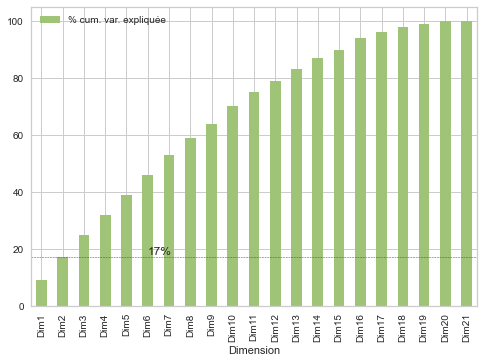

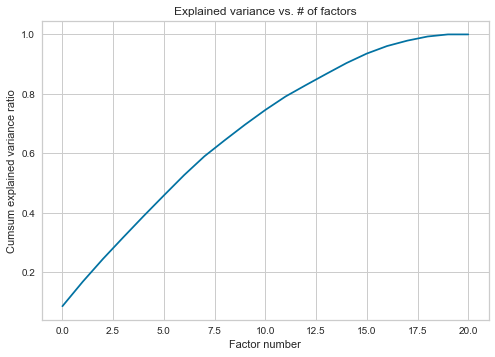

In [305]:
Z = pk_multi.amulti_acp_standard(df_acp2)
pk_multi.amulti_acp_choice_dim(df_acp2, Z)

Il faudrait 12 dimensions pour obtenir 80% de la variance expliquée.

In [306]:
df_acp.head(2)

,rw_id,rw_rating,rw_text,new_text,stemmed,lemmatized,text_tokens_pos_tagged,words_subjects,words_subjects_st,words_subjects_lem,...,tearsofhappinesswe_tfidf,terrace_tfidf,thanks_tfidf,tiles_tfidf,time_tfidf,wait_tfidf,walk_tfidf,warren_tfidf,wowwe_tfidf,yelpers_tfidf
0,e970XRRbYSDC83PEADB1gw,4.0,boo boo and i came here after a few hours at the louvre museum there was a long wait but it move...,boo boo came after few hours louvre museum was long wait but moved fast staff setup ...,boo boo came after few hour louvr museum was long wait but move fast staff setup make dine just,boo boo came after few hour louvre museum wa long wait but moved fast staff setup make dining just,boo boo came few hours louvre museum was long wait moved fast staff setup makes dining just,boo boo hours museum wait staff setup,boo boo hour louvr museum wait staff setup dine,boo boo hour louvre museum wa wait staff setup dining,...,0.0,0.0,0.000000,0.0,0.0,0.337569,0.0,0.0,0.0,0.0
1,WZgU_NdPlyXWHBuQi3LEPA,4.0,very good restaurant for french cuisine thanks to the reviewers before me leave a good guidance ...,very good restaurant french cuisine thanks reviewers before leave good guidance definitely ...,veri good restaur french cuisin thank review befor leav good guidanc definit accur true call res...,very good restaurant french cuisine thanks reviewer before leave good guidance definitely accura...,very good restaurant french cuisine thanks reviewers leave good guidance definitely accurate tru...,restaurant cuisine thanks reviewers guidance call restaurant,restaur cuisin thank review guidanc definit call restaur,restaurant cuisine thanks guidance call restaurant,...,0.0,0.0,0.340622,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


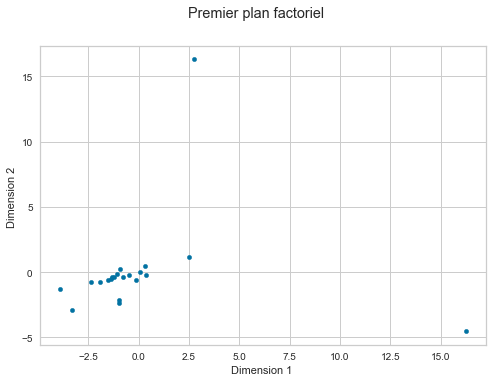

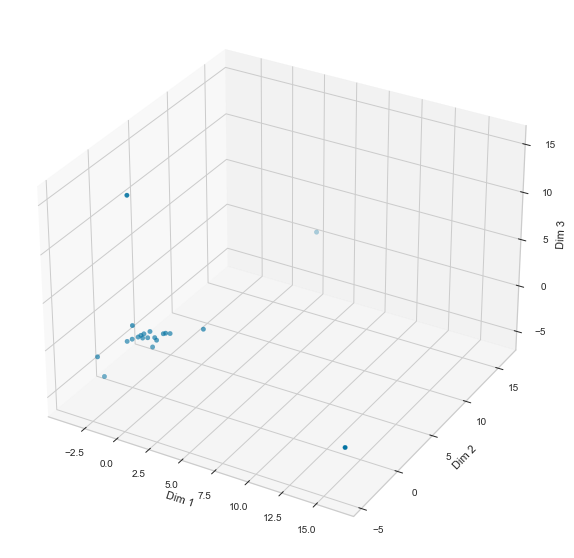

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\seaborn\axisgrid.py:130: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\seaborn\axisgrid.py:130: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



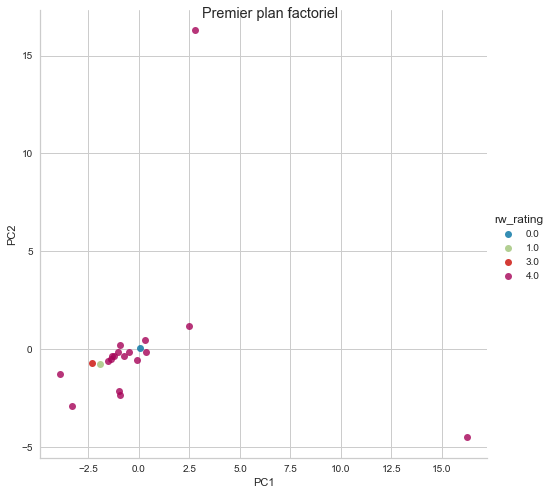

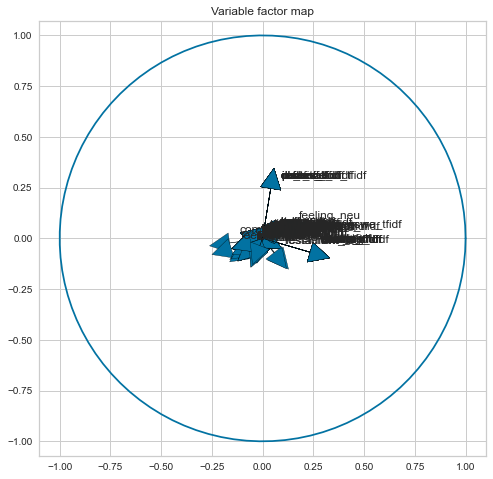

IndexError: index 21 is out of bounds for axis 0 with size 21

In [307]:
#pk.amultiacp_visualizer(df_acp2, Z, 3, df_acp,df_acp["customer_unique_id"], df_acp["order_id_size"], "order_id_size")
pk_multi.amultiacp_visualizer(df_acp2, Z, 3, df_acp, df_acp["words_subjects"], reviews["rw_rating"], "rw_rating")

### T-SNE

[t-SNE] Computing 20 nearest neighbors...
[t-SNE] Indexed 21 samples in 0.001s...
[t-SNE] Computed neighbors for 21 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 21 / 21
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.808231
[t-SNE] KL divergence after 300 iterations: 0.715921


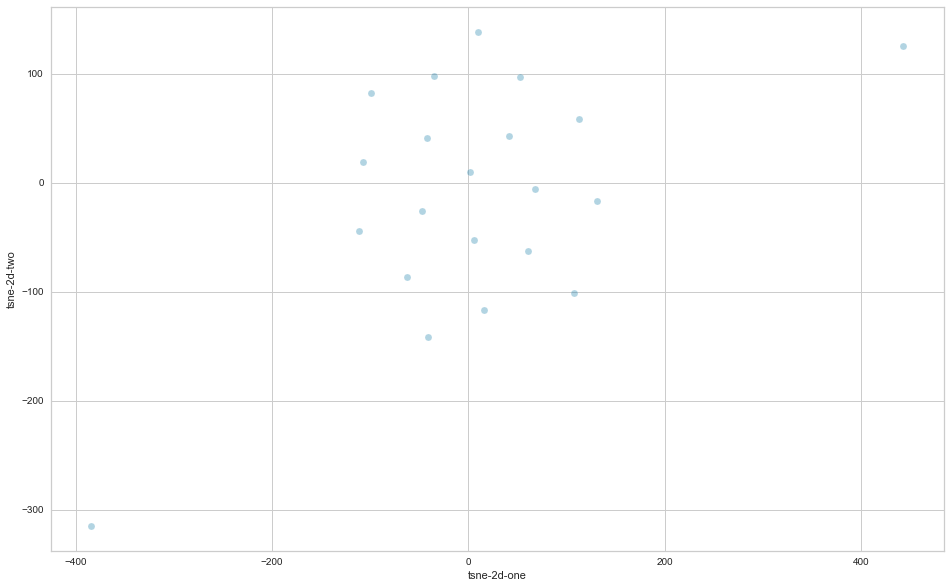

In [308]:
pk_multi.tsne_graph(df_acp2, group=0, by="")

### UMAP

In [309]:
pk_multi.umap_graphs(df_acp2)

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\numba\np\ufunc\parallel.py:366: NumbaWarning:

The TBB threading layer requires TBB version 2021 update 1 or later i.e., TBB_INTERFACE_VERSION >= 12010. Found TBB_INTERFACE_VERSION = 11103. The TBB threading layer is disabled.

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\plotly\io\_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\plotly\io\_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\plotly\io\_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\plotly\io\_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



# Modèle : LDA / K-means / Bert

In [310]:
gc.collect()

127660

In [311]:
reviews.head(2)

,rw_id,rw_rating,rw_text,new_text,stemmed,lemmatized,text_tokens_pos_tagged,words_subjects,words_subjects_st,words_subjects_lem,...,tearsofhappinesswe_tfidf,terrace_tfidf,thanks_tfidf,tiles_tfidf,time_tfidf,wait_tfidf,walk_tfidf,warren_tfidf,wowwe_tfidf,yelpers_tfidf
0,e970XRRbYSDC83PEADB1gw,4.0,boo boo and i came here after a few hours at the louvre museum there was a long wait but it move...,boo boo came after few hours louvre museum was long wait but moved fast staff setup ...,boo boo came after few hour louvr museum was long wait but move fast staff setup make dine just,boo boo came after few hour louvre museum wa long wait but moved fast staff setup make dining just,boo boo came few hours louvre museum was long wait moved fast staff setup makes dining just,boo boo hours museum wait staff setup,boo boo hour louvr museum wait staff setup dine,boo boo hour louvre museum wa wait staff setup dining,...,0.0,0.0,0.000000,0.0,0.0,0.337569,0.0,0.0,0.0,0.0
1,WZgU_NdPlyXWHBuQi3LEPA,4.0,very good restaurant for french cuisine thanks to the reviewers before me leave a good guidance ...,very good restaurant french cuisine thanks reviewers before leave good guidance definitely ...,veri good restaur french cuisin thank review befor leav good guidanc definit accur true call res...,very good restaurant french cuisine thanks reviewer before leave good guidance definitely accura...,very good restaurant french cuisine thanks reviewers leave good guidance definitely accurate tru...,restaurant cuisine thanks reviewers guidance call restaurant,restaur cuisin thank review guidanc definit call restaur,restaurant cuisine thanks guidance call restaurant,...,0.0,0.0,0.340622,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [312]:
for i in reviews["words_subjects"]:
    print(word_tokenize(i))

['boo', 'boo', 'hours', 'museum', 'wait', 'staff', 'setup']
['restaurant', 'cuisine', 'thanks', 'reviewers', 'guidance', 'call', 'restaurant']
['lowkey', 'place', 'dine', 'server', 'americans']
['hotel', 'place', 'serve', 'cuisine', 'outdoor', 'dining']
[]
['minute', 'walk', 'louvre', 'restaurant', 'cluster', 'eateries', 'health', 'pass']
['arrondissement', 'warren', 'sthonore']
['wowwe', 'meal', 'nothing', 'tiles', 'funky', 'area']
['neighborhood', 'cous', 'pots', 'service']
['restaurant', 'history', 'decadence', 'rooms']
['time', 'staff', 'people', 'solo', 'confit']
['terrace', 'food', 'tartare', 'soup', 'poke', 'bowl', 'someone']
['thanks', 'yelpers', 'spot', 'lunchtime', 'parisian', 'food', 'lunch', 'rush']
['service', 'night', 'place', 'food', 'prices']
['food', 'food', 'menu']
['decor', 'service', 'bit', 'food']
['stars', 'appetizers', 'service', 'location', 'okay', 'food', 'luck', 'restaurant', 'food']
['experience', 'fumoir', 'food', 'setting']
['tearsofhappinesswe', 'distance'

In [313]:
reviews["token_subjects"] = [word_tokenize(text) for text in reviews["words_subjects"]]

In [314]:
reviews

,rw_id,rw_rating,rw_text,new_text,stemmed,lemmatized,text_tokens_pos_tagged,words_subjects,words_subjects_st,words_subjects_lem,...,terrace_tfidf,thanks_tfidf,tiles_tfidf,time_tfidf,wait_tfidf,walk_tfidf,warren_tfidf,wowwe_tfidf,yelpers_tfidf,token_subjects
0,e970XRRbYSDC83PEADB1gw,4.0,boo boo and i came here after a few hours at the louvre museum there was a long wait but it move...,boo boo came after few hours louvre museum was long wait but moved fast staff setup ...,boo boo came after few hour louvr museum was long wait but move fast staff setup make dine just,boo boo came after few hour louvre museum wa long wait but moved fast staff setup make dining just,boo boo came few hours louvre museum was long wait moved fast staff setup makes dining just,boo boo hours museum wait staff setup,boo boo hour louvr museum wait staff setup dine,boo boo hour louvre museum wa wait staff setup dining,...,0.000000,0.000000,0.000000,0.000000,0.337569,0.000000,0.00000,0.000000,0.000000,"[boo, boo, hours, museum, wait, staff, setup]"
1,WZgU_NdPlyXWHBuQi3LEPA,4.0,very good restaurant for french cuisine thanks to the reviewers before me leave a good guidance ...,very good restaurant french cuisine thanks reviewers before leave good guidance definitely ...,veri good restaur french cuisin thank review befor leav good guidanc definit accur true call res...,very good restaurant french cuisine thanks reviewer before leave good guidance definitely accura...,very good restaurant french cuisine thanks reviewers leave good guidance definitely accurate tru...,restaurant cuisine thanks reviewers guidance call restaurant,restaur cuisin thank review guidanc definit call restaur,restaurant cuisine thanks guidance call restaurant,...,0.000000,0.340622,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,"[restaurant, cuisine, thanks, reviewers, guidance, call, restaurant]"
2,9zPoJDR7H1s0P0SeexSIwg,4.0,casual and lowkey place it was very relaxing to dine here the server was keen on recognizing us ...,casual lowkey place was very relaxing dine server was keen recognizing us americans conv...,casual lowkey place was veri relax dine server was keen recogn us american convers us bring,casual lowkey place wa very relaxing dine server wa keen recognizing u american conversed u brin...,casual lowkey place was very relaxing dine server was keen recognizing us americans conversed us...,lowkey place dine server americans,lowkey place dine server convers,place dine server bringing,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,"[lowkey, place, dine, server, americans]"
3,hiVILjoj4qcKApkY0q9CHw,4.0,the hostess from my hotel recommended this place as they serve authentic french cuisine came to...,hostess hotel recommended place serve authentic french cuisine came restaurant outdoor...,hostess hotel recommend place serv authent french cuisin came restaur outdoor dine was pack,hostess hotel recommended place serve authentic french cuisine came restaurant outdoor dining wa...,hostess hotel recommended place serve authentic french cuisine came restaurant outdoor dining wa...,hotel place serve cuisine outdoor dining,hotel place authent cuisin dine pack,hotel place serve cuisine outdoor wa,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,"[hotel, place, serve, cuisine, outdoor, dining]"
4,NaN,0.0,,,,,,,,,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,[]
5,6VRDbCMuGKSxcYiNx6Sg4g,4.0,a five minute walk from the louvre this restaurant was among a cluster of other eateries they a...,five minute walk louvre restaurant was among cluster other eateries also checked health...,five minut walk louvr restaur was among cluster other eateri also check health pass like was,five minute walk louvre restaurant wa among cluster other eatery also checked health pas like wa,minute walk louvre restaurant was cluster other eateries also checked health pass was,minute walk louvre resta

In [315]:
# Create Dictionary
id2word = corpora.Dictionary(reviews["token_subjects"])

# Create Corpus
texts = reviews["token_subjects"]

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 2), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1)]]


In [316]:
id2word[0]

'boo'

In [317]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('boo', 2),
  ('hours', 1),
  ('museum', 1),
  ('setup', 1),
  ('staff', 1),
  ('wait', 1)]]

In [318]:
corpus

[[(0, 2), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1)],
 [(6, 1), (7, 1), (8, 1), (9, 2), (10, 1), (11, 1)],
 [(12, 1), (13, 1), (14, 1), (15, 1), (16, 1)],
 [(7, 1), (15, 1), (17, 1), (18, 1), (19, 1), (20, 1)],
 [],
 [(9, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1)],
 [(28, 1), (29, 1), (30, 1)],
 [(31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1)],
 [(37, 1), (38, 1), (39, 1), (40, 1)],
 [(9, 1), (41, 1), (42, 1), (43, 1)],
 [(4, 1), (44, 1), (45, 1), (46, 1), (47, 1)],
 [(48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1)],
 [(11, 1), (49, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1)],
 [(15, 1), (40, 1), (49, 1), (61, 1), (62, 1)],
 [(49, 2), (63, 1)],
 [(40, 1), (49, 1), (64, 1), (65, 1)],
 [(9, 1), (40, 1), (49, 2), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1)],
 [(49, 1), (71, 1), (72, 1), (73, 1)],
 [(74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1)],
 [(40, 1), (49, 1), (80, 1)],
 [(81, 1), (82, 1), (83, 1), (84, 1), (85, 1), (86, 1

In [319]:
from gensim.models.ldamodel import LdaModel

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics, random_state=1, update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=id2word, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


In [320]:
gc.collect()

0

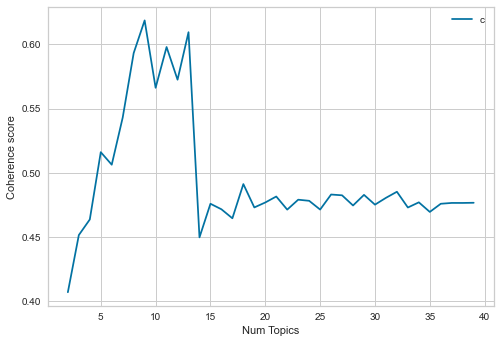

Num Topics = 2  has Coherence Value of 0.4069
Num Topics = 3  has Coherence Value of 0.4514
Num Topics = 4  has Coherence Value of 0.4636
Num Topics = 5  has Coherence Value of 0.516
Num Topics = 6  has Coherence Value of 0.5062
Num Topics = 7  has Coherence Value of 0.543
Num Topics = 8  has Coherence Value of 0.5932
Num Topics = 9  has Coherence Value of 0.6187
Num Topics = 10  has Coherence Value of 0.5662
Num Topics = 11  has Coherence Value of 0.598
Num Topics = 12  has Coherence Value of 0.5725
Num Topics = 13  has Coherence Value of 0.6095
Num Topics = 14  has Coherence Value of 0.4496
Num Topics = 15  has Coherence Value of 0.4758
Num Topics = 16  has Coherence Value of 0.4715
Num Topics = 17  has Coherence Value of 0.4645
Num Topics = 18  has Coherence Value of 0.4912
Num Topics = 19  has Coherence Value of 0.473
Num Topics = 20  has Coherence Value of 0.4768
Num Topics = 21  has Coherence Value of 0.4815
Num Topics = 22  has Coherence Value of 0.4713
Num Topics = 23  has Cohe

In [321]:
# Calculer les scores de cohérence entre 2 et 40 topics (Cela peut prendre un certain temps)
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, start=2, limit=40, step=1)

# Afficher un graphique
limit=40
start=2
step=1
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Affchier les coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))  #le 4 correspond au nombre de décimales du c

In [331]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [332]:
print(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0, '0.062*"dine" + 0.062*"americans" + 0.062*"place" + 0.062*"server" + 0.062*"bit" + 0.062*"lowkey" + 0.062*"decor" + 0.062*"service" + 0.062*"food" + 0.006*"restaurant"'), (1, '0.056*"cafe" + 0.056*"corner" + 0.056*"places" + 0.056*"du" + 0.056*"cochon" + 0.056*"reservation" + 0.056*"instance" + 0.056*"cous" + 0.056*"neighborhood" + 0.056*"pots"'), (2, '0.133*"boo" + 0.070*"hours" + 0.070*"museum" + 0.070*"setup" + 0.070*"staff" + 0.070*"wait" + 0.006*"food" + 0.006*"service" + 0.006*"restaurant" + 0.006*"place"'), (3, '0.116*"food" + 0.078*"service" + 0.041*"appetizers" + 0.041*"place" + 0.041*"luck" + 0.041*"restaurant" + 0.041*"okay" + 0.041*"stars" + 0.041*"location" + 0.041*"dining"'), (4, '0.118*"food" + 0.062*"area" + 0.062*"wowwe" + 0.062*"meal" + 0.062*"tiles" + 0.062*"nothing" + 0.062*"funky" + 0.062*"menu" + 0.006*"service" + 0.006*"restaurant"'), (5, '0.108*"restaurant" + 0.038*"pass" + 0.038*"eateries" + 0.038*"health" + 0.038*"thanks" + 0.038*"guidance" + 0.038*"cuisi

In [333]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=reviews["token_subjects"], dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -5.3398452454859076

Coherence Score:  0.5755243031674349


In [334]:
from pprint import pprint

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.062*"dine" + 0.062*"americans" + 0.062*"place" + 0.062*"server" + '
  '0.062*"bit" + 0.062*"lowkey" + 0.062*"decor" + 0.062*"service" + '
  '0.062*"food" + 0.006*"restaurant"'),
 (1,
  '0.056*"cafe" + 0.056*"corner" + 0.056*"places" + 0.056*"du" + '
  '0.056*"cochon" + 0.056*"reservation" + 0.056*"instance" + 0.056*"cous" + '
  '0.056*"neighborhood" + 0.056*"pots"'),
 (2,
  '0.133*"boo" + 0.070*"hours" + 0.070*"museum" + 0.070*"setup" + '
  '0.070*"staff" + 0.070*"wait" + 0.006*"food" + 0.006*"service" + '
  '0.006*"restaurant" + 0.006*"place"'),
 (3,
  '0.116*"food" + 0.078*"service" + 0.041*"appetizers" + 0.041*"place" + '
  '0.041*"luck" + 0.041*"restaurant" + 0.041*"okay" + 0.041*"stars" + '
  '0.041*"location" + 0.041*"dining"'),
 (4,
  '0.118*"food" + 0.062*"area" + 0.062*"wowwe" + 0.062*"meal" + 0.062*"tiles" '
  '+ 0.062*"nothing" + 0.062*"funky" + 0.062*"menu" + 0.006*"service" + '
  '0.006*"restaurant"'),
 (5,
  '0.108*"restaurant" + 0.038*"pass" + 0.038*"eateries" 

In [335]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=texts)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2.0,0.9274,"boo, hours, museum, setup, staff, wait, food, service, restaurant, place","[boo, boo, hours, museum, wait, staff, setup]"
1,1,5.0,0.9303,"restaurant, pass, eateries, health, thanks, guidance, cuisine, reviewers, walk, cluster","[restaurant, cuisine, thanks, reviewers, guidance, call, restaurant]"
2,2,0.0,0.9032,"dine, americans, place, server, bit, lowkey, decor, service, food, restaurant","[lowkey, place, dine, server, americans]"
3,3,3.0,0.9196,"food, service, appetizers, place, luck, restaurant, okay, stars, location, dining","[hotel, place, serve, cuisine, outdoor, dining]"
4,4,5.0,0.1198,"restaurant, pass, eateries, health, thanks, guidance, cuisine, reviewers, walk, cluster",[]
5,5,5.0,0.9384,"restaurant, pass, eateries, health, thanks, guidance, cuisine, reviewers, walk, cluster","[minute, walk, louvre, restaurant, cluster, eateries, health, pass]"
6,6,6.0,0.8493,"night, prices, place, service, arrondissement, food, sthonore, warren, restaurant, pots","[arrondissement, warren, sthonore]"
7,7,4.0,0.9178,"food, area, wowwe, meal, tiles, nothing, funky, menu, service, restaurant","[wowwe, meal, nothing, tiles, funky, area]"
8,8,1.0,0.8822,"cafe, corner, places, du, cochon, reservation, instance, cous, neighborhood, pots","[neighborhood, cous, pots, service]"
9,9,8.0,0.8822,"pasta, share, seafood, salad, distance, tearsofhappinesswe, rooms, decadence, history, restaurant","[restaurant, history, decadence, rooms]"


In [348]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [349]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=reviews["token_subjects"], dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -5.003126539625563

Coherence Score:  0.3752954017235906


In [350]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=texts)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2.0,0.9619,"boo, staff, pass, hours, eateries, walk, minute, cluster, health, museum","[boo, boo, hours, museum, wait, staff, setup]"
1,1,3.0,0.9633,"food, restaurant, service, cuisine, thanks, appetizers, luck, okay, guidance, location","[restaurant, cuisine, thanks, reviewers, guidance, call, restaurant]"
2,2,0.0,0.9456,"place, food, service, dine, outdoor, hotel, americans, serve, dining, cuisine","[lowkey, place, dine, server, americans]"
3,3,0.0,0.9541,"place, food, service, dine, outdoor, hotel, americans, serve, dining, cuisine","[hotel, place, serve, cuisine, outdoor, dining]"
4,4,3.0,0.2795,"food, restaurant, service, cuisine, thanks, appetizers, luck, okay, guidance, location",[]
5,5,2.0,0.9664,"boo, staff, pass, hours, eateries, walk, minute, cluster, health, museum","[minute, walk, louvre, restaurant, cluster, eateries, health, pass]"
6,6,1.0,0.9164,"food, thanks, cafe, lunchtime, someone, terrace, corner, reservation, yelpers, rush","[arrondissement, warren, sthonore]"
7,7,2.0,0.9559,"boo, staff, pass, hours, eateries, walk, minute, cluster, health, museum","[wowwe, meal, nothing, tiles, funky, area]"
8,8,1.0,0.9355,"food, thanks, cafe, lunchtime, someone, terrace, corner, reservation, yelpers, rush","[neighborhood, cous, pots, service]"
9,9,3.0,0.9382,"food, restaurant, service, cuisine, thanks, appetizers, luck, okay, guidance, location","[restaurant, history, decadence, rooms]"


In [351]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9541,"place, food, service, dine, outdoor, hotel, americans, serve, dining, cuisine","[hotel, place, serve, cuisine, outdoor, dining]"
1,1.0,0.9663,"food, thanks, cafe, lunchtime, someone, terrace, corner, reservation, yelpers, rush","[thanks, yelpers, spot, lunchtime, parisian, food, lunch, rush]"
2,2.0,0.9664,"boo, staff, pass, hours, eateries, walk, minute, cluster, health, museum","[minute, walk, louvre, restaurant, cluster, eateries, health, pass]"
3,3.0,0.9711,"food, restaurant, service, cuisine, thanks, appetizers, luck, okay, guidance, location","[stars, appetizers, service, location, okay, food, luck, restaurant, food]"


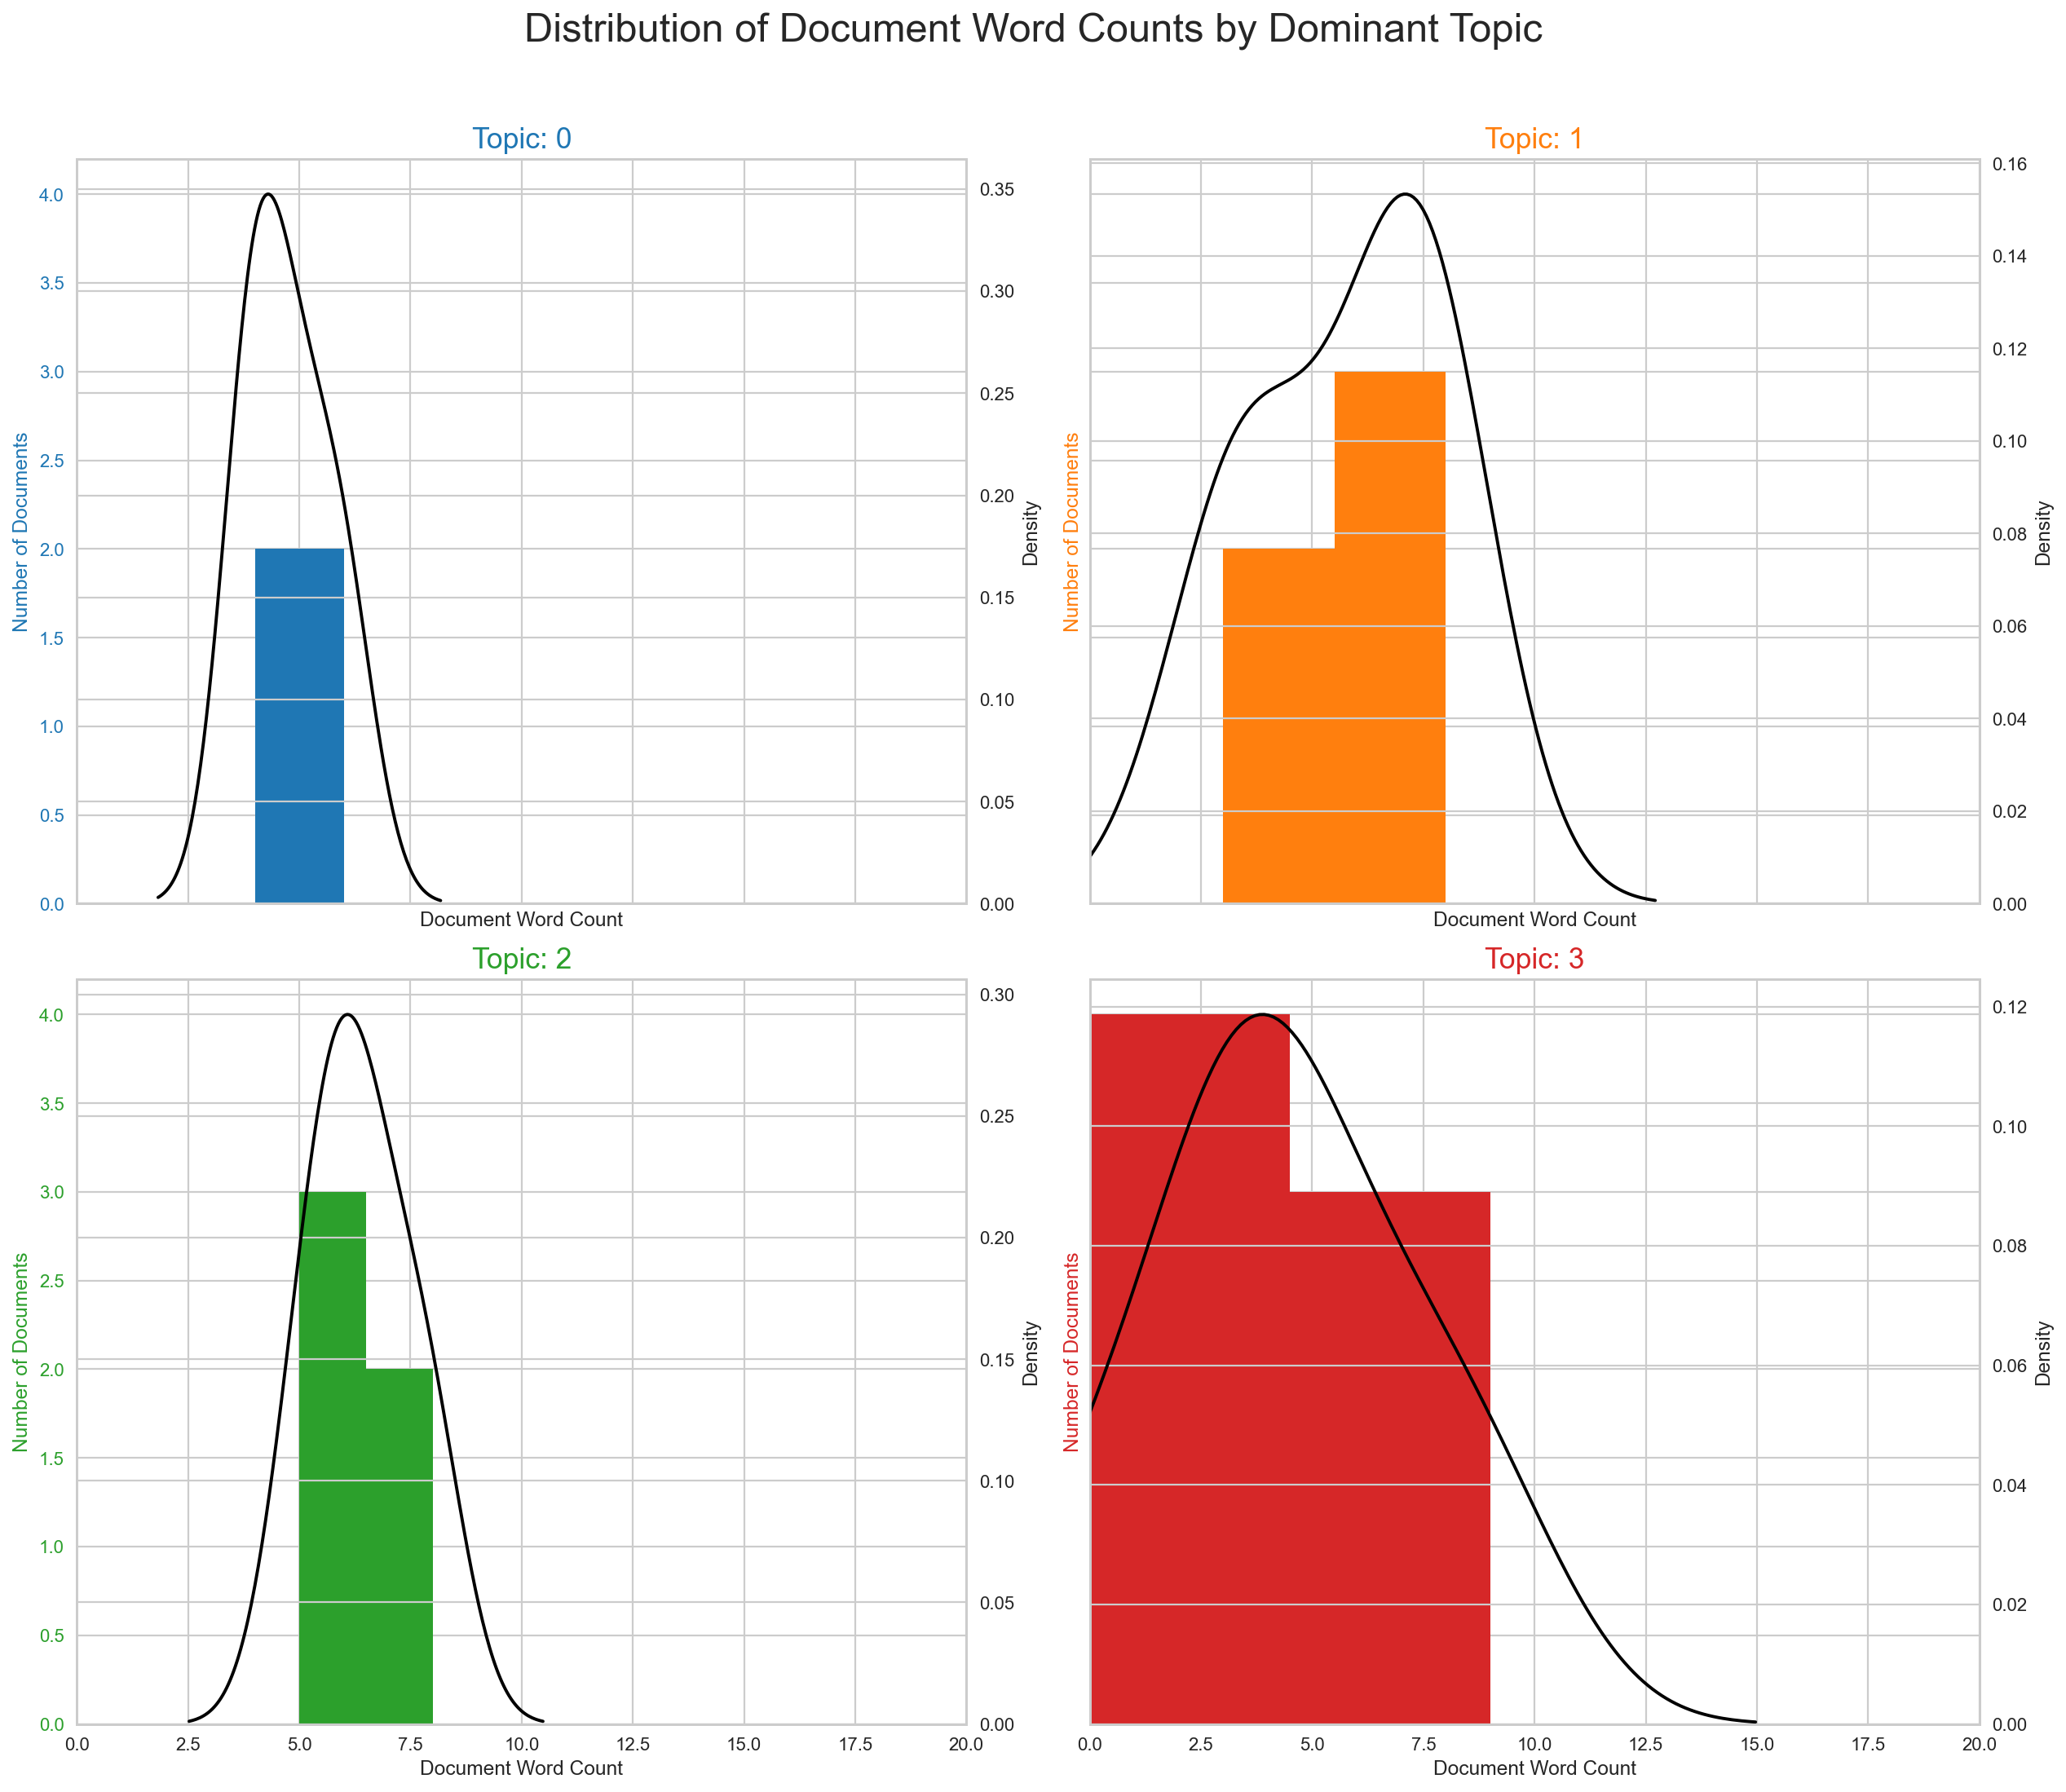

In [363]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 2, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 20), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,20,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

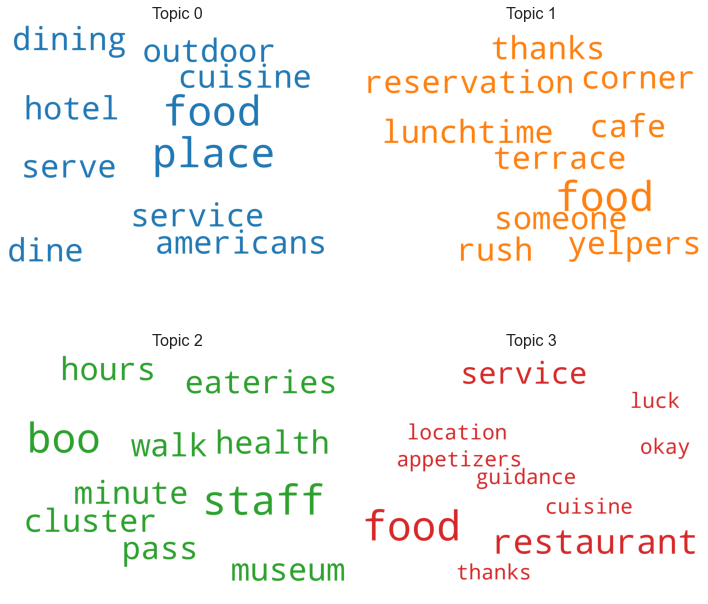

In [364]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

C:\Users\aurel\AppData\Local\Temp\ipykernel_8832\2913163039.py:24: UserWarning:

FixedFormatter should only be used together with FixedLocator

C:\Users\aurel\AppData\Local\Temp\ipykernel_8832\2913163039.py:24: UserWarning:

FixedFormatter should only be used together with FixedLocator

C:\Users\aurel\AppData\Local\Temp\ipykernel_8832\2913163039.py:24: UserWarning:

FixedFormatter should only be used together with FixedLocator

C:\Users\aurel\AppData\Local\Temp\ipykernel_8832\2913163039.py:24: UserWarning:

FixedFormatter should only be used together with FixedLocator



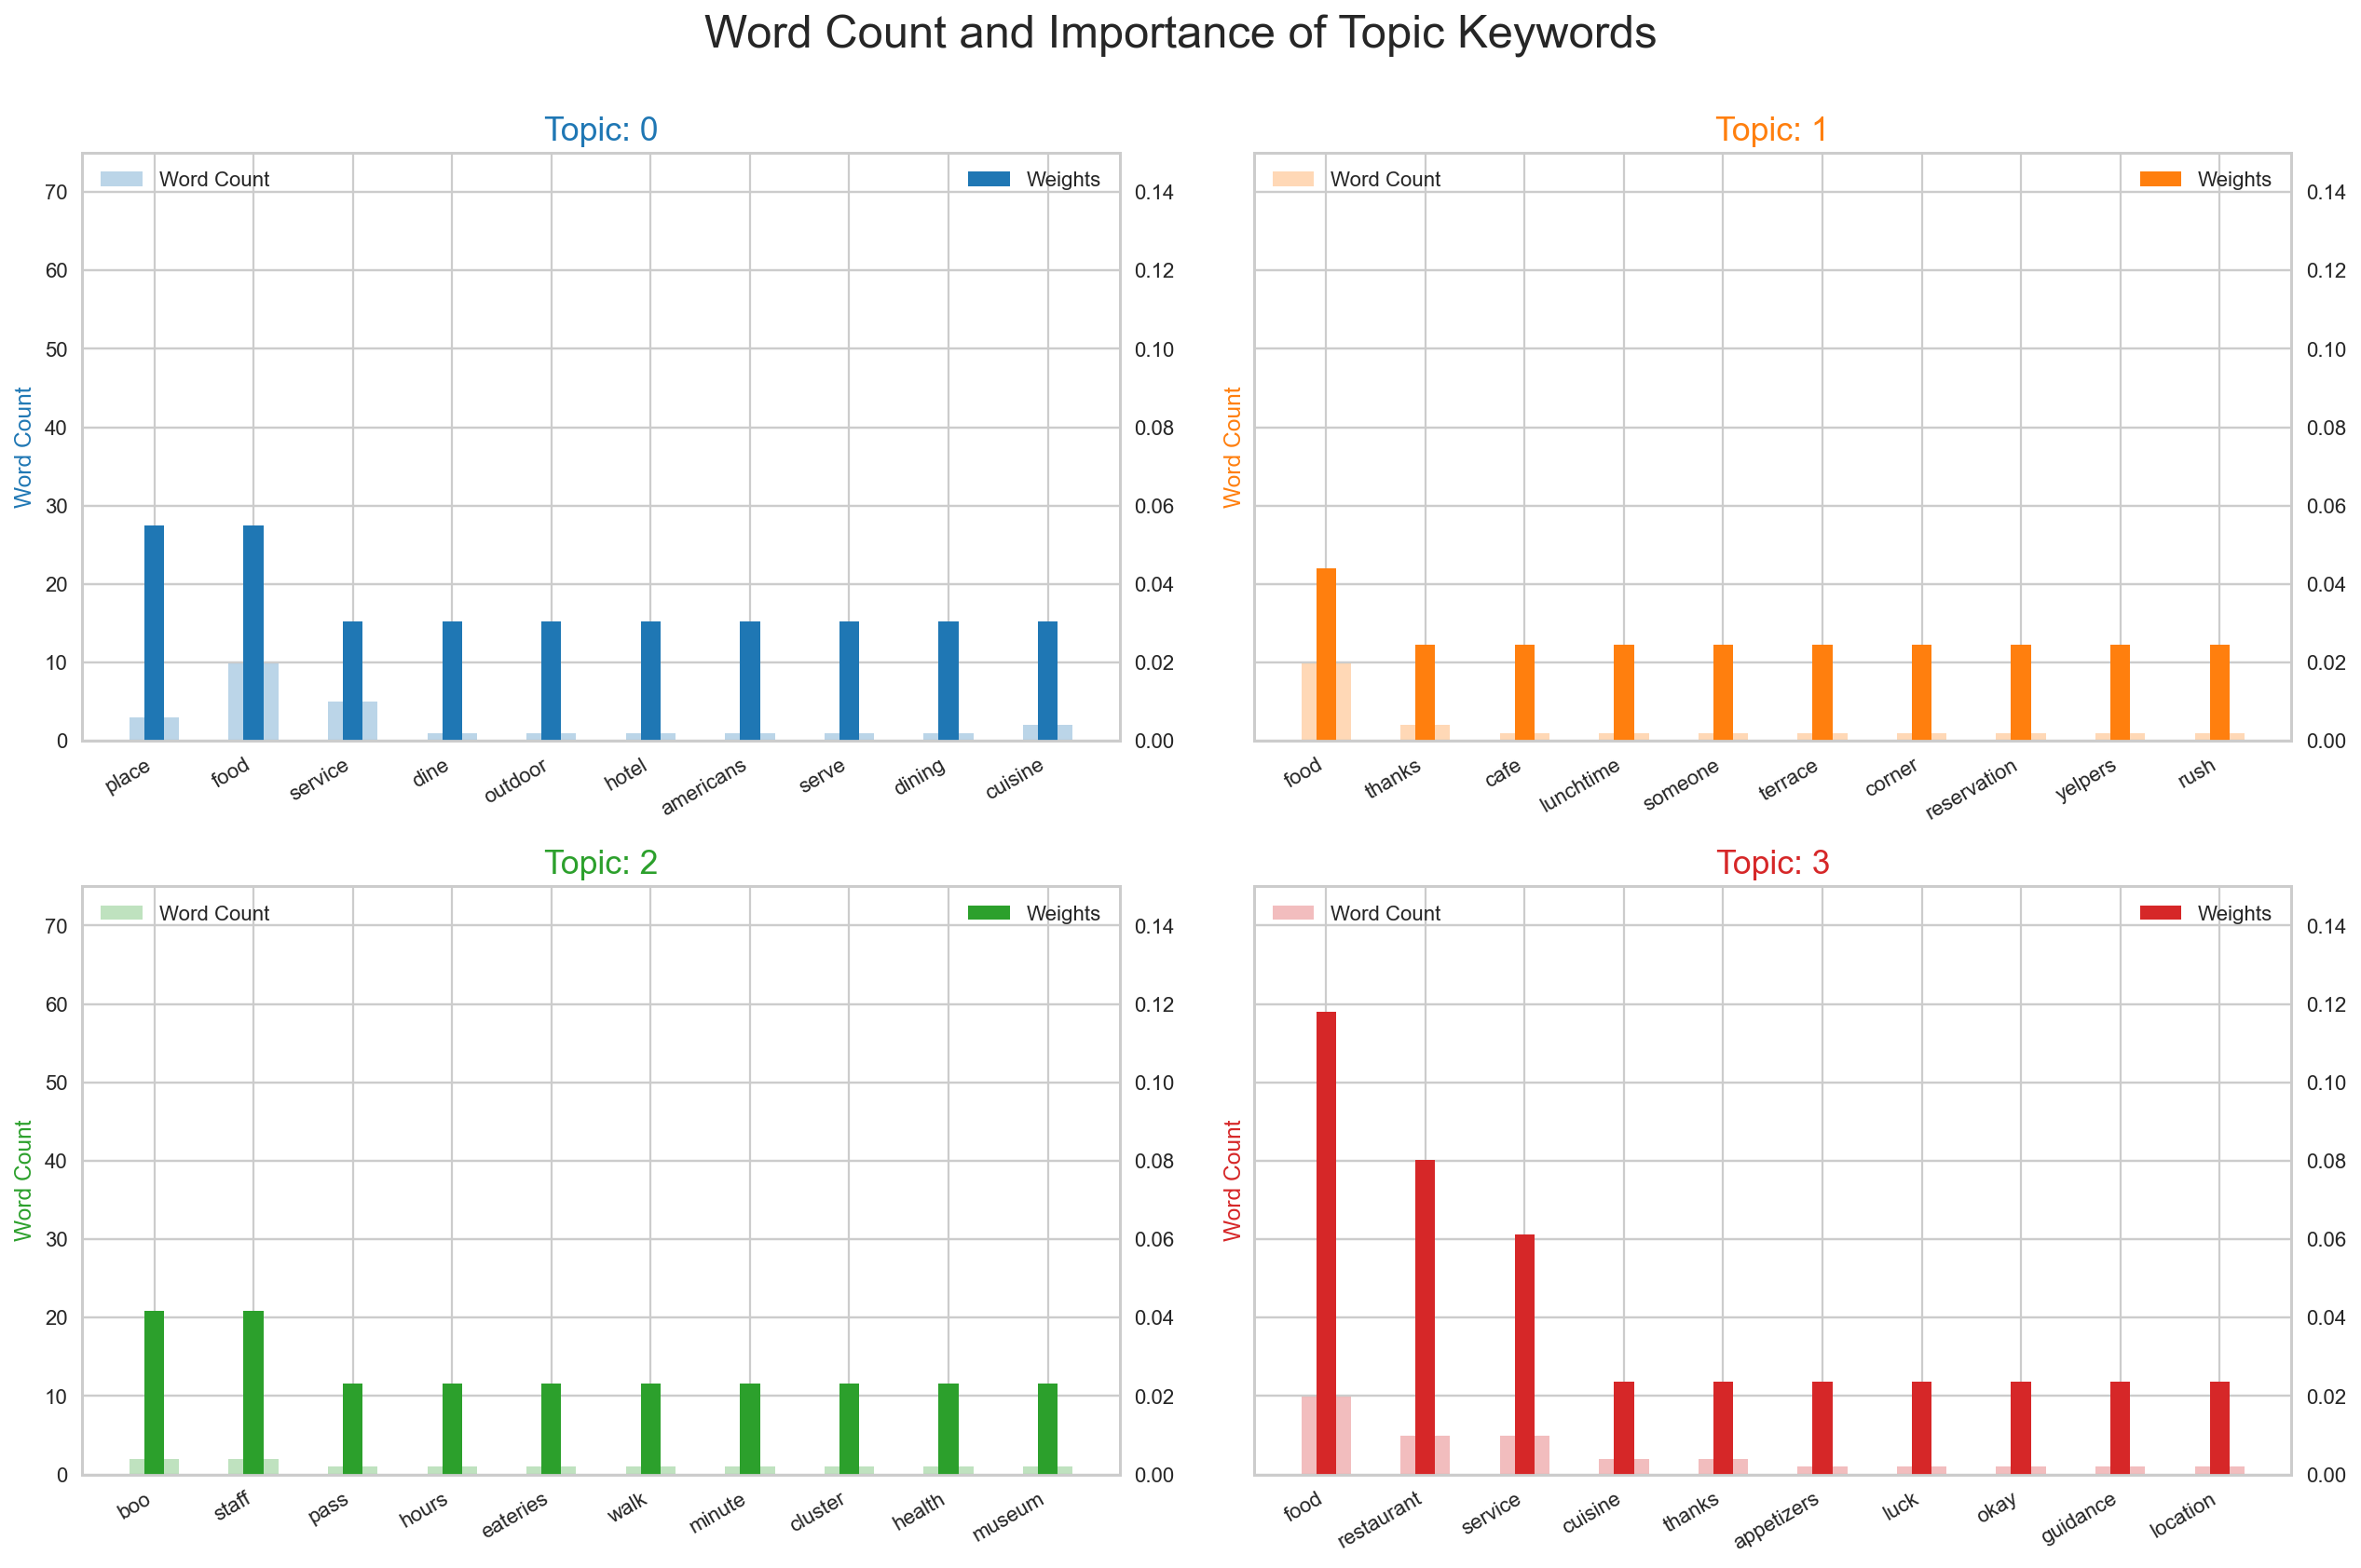

In [388]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in texts for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.15); ax.set_ylim(0, 75)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

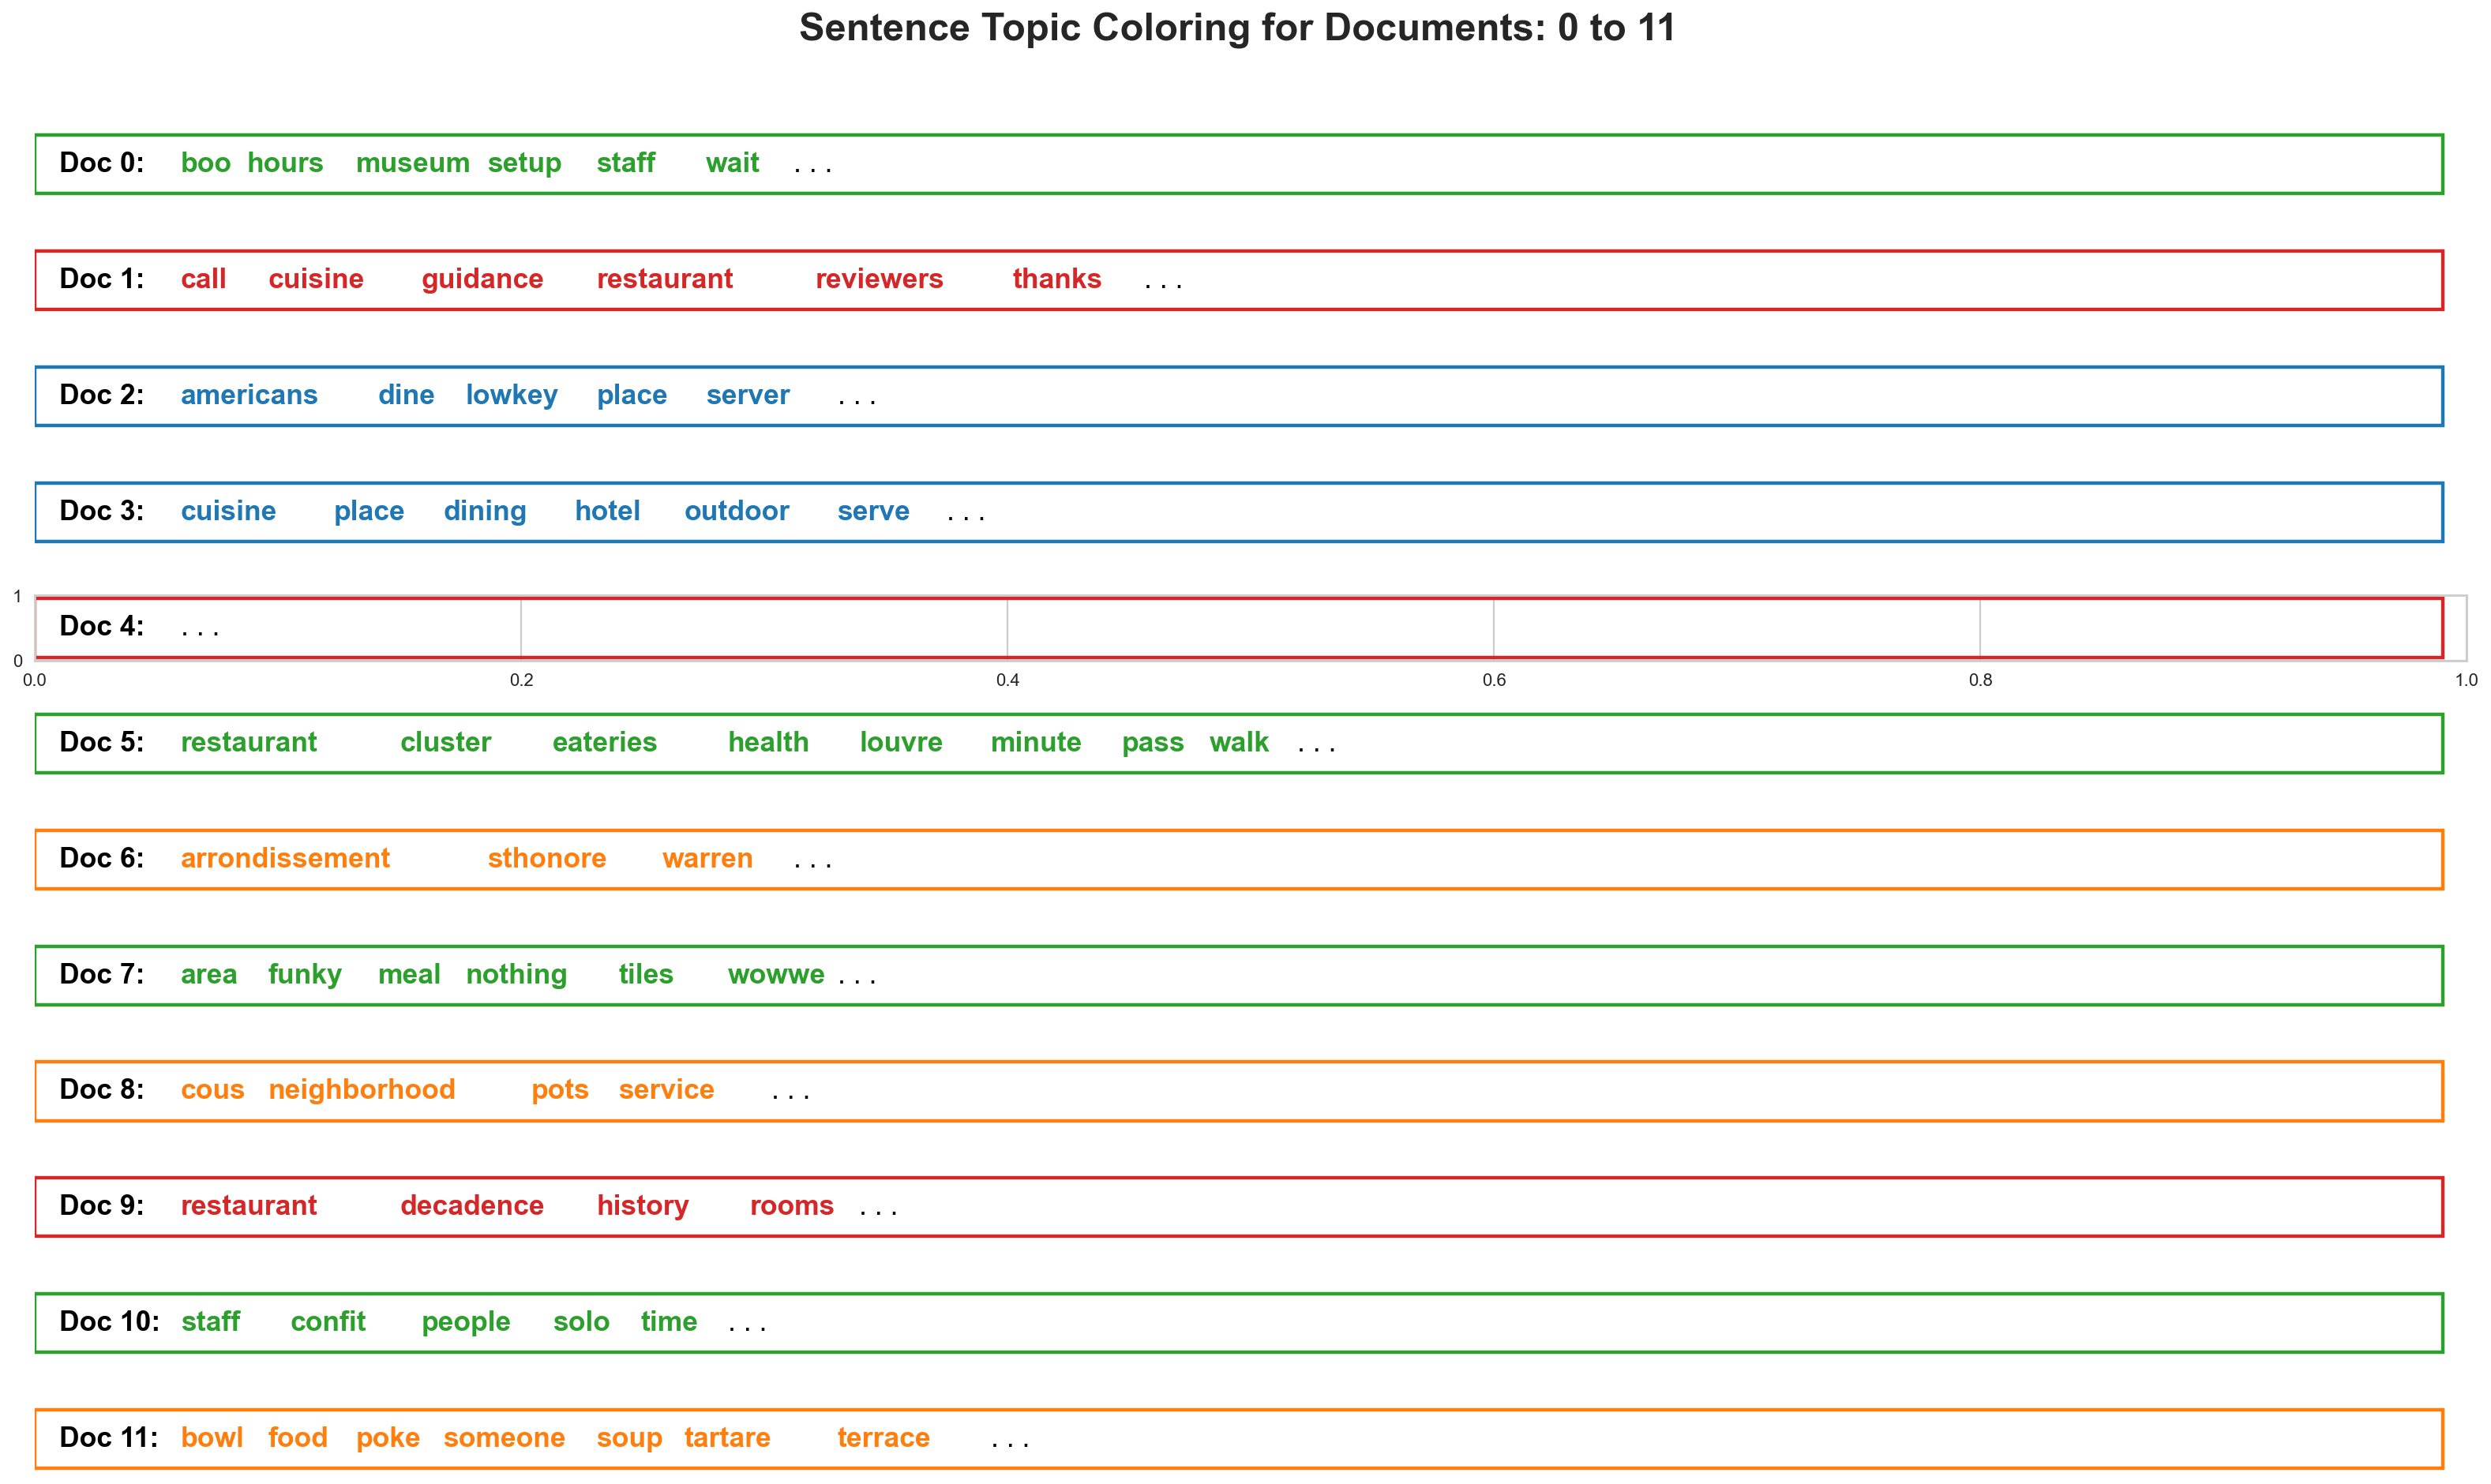

In [366]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()    

In [367]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
import matplotlib.colors as mcolors

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 19 nearest neighbors...
[t-SNE] Indexed 20 samples in 0.001s...
[t-SNE] Computed neighbors for 20 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 20 / 20
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.615494
[t-SNE] KL divergence after 1000 iterations: 0.370872


D:\Users\Aurel\Anaconda3\envs\venv_006\lib\site-packages\bokeh\io\notebook.py:487: DeprecationWarning:

The `source` parameter emit a  deprecation warning since IPython 8.0, it had no effects for a long time and will  be removed in future versions.



Loading BokehJS ...

D:\Users\Aurel\Anaconda3\envs\venv_006\lib\site-packages\bokeh\io\notebook.py:487: DeprecationWarning:

The `source` parameter emit a  deprecation warning since IPython 8.0, it had no effects for a long time and will  be removed in future versions.



D:\Users\Aurel\Anaconda3\envs\venv_006\lib\site-packages\bokeh\io\notebook.py:487: DeprecationWarning:

The `source` parameter emit a  deprecation warning since IPython 8.0, it had no effects for a long time and will  be removed in future versions.



D:\Users\Aurel\Anaconda3\envs\venv_006\lib\site-packages\bokeh\io\notebook.py:487: DeprecationWarning:

The `source` parameter emit a  deprecation warning since IPython 8.0, it had no effects for a long time and will  be removed in future versions.



In [113]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=id2word)
vis

ModuleNotFoundError: No module named 'pyLDAvis.gensim'

## Bert

In [101]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

example_text = 'I will watch Memento tonight'
bert_input = tokenizer(example_text,padding='max_length', max_length = 10, 
                       truncation=True, return_tensors="pt")


print(bert_input['input_ids'])
print(bert_input['token_type_ids'])
print(bert_input['attention_mask'])

tensor([[  101,   146,  1209,  2824,  2508, 26173,  3568,   102,     0,     0]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0]])


In [4]:
example_text = tokenizer.decode(bert_input.input_ids[0])

print(example_text)

[CLS] I will watch Memento tonight [SEP] [PAD] [PAD]


In [102]:
import gc
gc.collect()

3565

### K-means

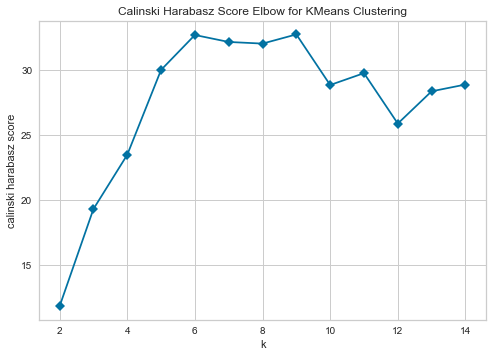

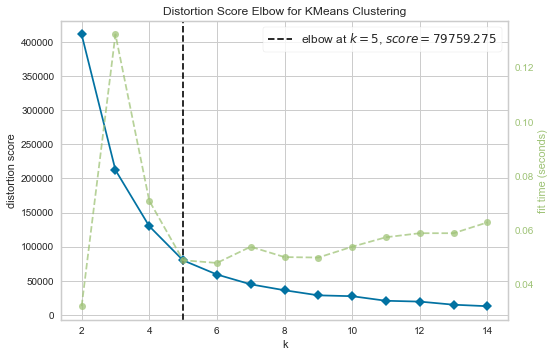

In [368]:
pk_multi_unsp.amulti_kmeans_elbow(df_acp2)

In [369]:
X = df_acp2.copy()

In [370]:
silhouette, cluster_res = pk_multi_unsp.kmsplus_iter(1, X, 5, 500, 0)

Silhouette Coefficient:  0.11070094632111901  - nb clusters :  5
-----------------------------------------------------------------------------------


In [375]:
df_km = pk_multi_unsp.kmplus_assignclass(df_acp,X, 5, 1000)

In [376]:
df_km

,rw_id,rw_rating,rw_text,new_text,stemmed,lemmatized,text_tokens_pos_tagged,words_subjects,words_subjects_st,words_subjects_lem,...,terrace_tfidf,thanks_tfidf,tiles_tfidf,time_tfidf,wait_tfidf,walk_tfidf,warren_tfidf,wowwe_tfidf,yelpers_tfidf,classe
0,e970XRRbYSDC83PEADB1gw,4.0,boo boo and i came here after a few hours at the louvre museum there was a long wait but it move...,boo boo came after few hours louvre museum was long wait but moved fast staff setup ...,boo boo came after few hour louvr museum was long wait but move fast staff setup make dine just,boo boo came after few hour louvre museum wa long wait but moved fast staff setup make dining just,boo boo came few hours louvre museum was long wait moved fast staff setup makes dining just,boo boo hours museum wait staff setup,boo boo hour louvr museum wait staff setup dine,boo boo hour louvre museum wa wait staff setup dining,...,0.000000,0.000000,0.000000,0.000000,0.337569,0.000000,0.00000,0.000000,0.000000,3
1,WZgU_NdPlyXWHBuQi3LEPA,4.0,very good restaurant for french cuisine thanks to the reviewers before me leave a good guidance ...,very good restaurant french cuisine thanks reviewers before leave good guidance definitely ...,veri good restaur french cuisin thank review befor leav good guidanc definit accur true call res...,very good restaurant french cuisine thanks reviewer before leave good guidance definitely accura...,very good restaurant french cuisine thanks reviewers leave good guidance definitely accurate tru...,restaurant cuisine thanks reviewers guidance call restaurant,restaur cuisin thank review guidanc definit call restaur,restaurant cuisine thanks guidance call restaurant,...,0.000000,0.340622,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1
2,9zPoJDR7H1s0P0SeexSIwg,4.0,casual and lowkey place it was very relaxing to dine here the server was keen on recognizing us ...,casual lowkey place was very relaxing dine server was keen recognizing us americans conv...,casual lowkey place was veri relax dine server was keen recogn us american convers us bring,casual lowkey place wa very relaxing dine server wa keen recognizing u american conversed u brin...,casual lowkey place was very relaxing dine server was keen recognizing us americans conversed us...,lowkey place dine server americans,lowkey place dine server convers,place dine server bringing,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,2
3,hiVILjoj4qcKApkY0q9CHw,4.0,the hostess from my hotel recommended this place as they serve authentic french cuisine came to...,hostess hotel recommended place serve authentic french cuisine came restaurant outdoor...,hostess hotel recommend place serv authent french cuisin came restaur outdoor dine was pack,hostess hotel recommended place serve authentic french cuisine came restaurant outdoor dining wa...,hostess hotel recommended place serve authentic french cuisine came restaurant outdoor dining wa...,hotel place serve cuisine outdoor dining,hotel place authent cuisin dine pack,hotel place serve cuisine outdoor wa,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1
4,NaN,0.0,,,,,,,,,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1
5,6VRDbCMuGKSxcYiNx6Sg4g,4.0,a five minute walk from the louvre this restaurant was among a cluster of other eateries they a...,five minute walk louvre restaurant was among cluster other eateries also checked health...,five minut walk louvr restaur was among cluster other eateri also check health pass like was,five minute walk louvre restaurant wa among cluster other eatery also checked health pas like wa,minute walk louvre restaurant was cluster other eateries also checked health pass was,minute walk louvre restaurant cluster eateries health pass,minut walk louvr restaur cluster eateri health pass,minute walk louvre restaurant wa cluster eatery health pas wa,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.364338,0.0000

In [378]:
pk_multi_unsp.graphs_profils(df_km,0,4, ["feeling_neu", "feeling_neg", "feeling_pos"])

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\plotly\io\_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\plotly\io\_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\plotly\io\_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\plotly\io\_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\plotly\io\_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\plotly\io\_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\plotly\io\_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\plotly\io\_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\plotly\io\_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\plotly\io\_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



In [379]:
df_km.head(2)

,rw_id,rw_rating,rw_text,new_text,stemmed,lemmatized,text_tokens_pos_tagged,words_subjects,words_subjects_st,words_subjects_lem,...,terrace_tfidf,thanks_tfidf,tiles_tfidf,time_tfidf,wait_tfidf,walk_tfidf,warren_tfidf,wowwe_tfidf,yelpers_tfidf,classe
0,e970XRRbYSDC83PEADB1gw,4.0,boo boo and i came here after a few hours at the louvre museum there was a long wait but it move...,boo boo came after few hours louvre museum was long wait but moved fast staff setup ...,boo boo came after few hour louvr museum was long wait but move fast staff setup make dine just,boo boo came after few hour louvre museum wa long wait but moved fast staff setup make dining just,boo boo came few hours louvre museum was long wait moved fast staff setup makes dining just,boo boo hours museum wait staff setup,boo boo hour louvr museum wait staff setup dine,boo boo hour louvre museum wa wait staff setup dining,...,0.0,0.000000,0.0,0.0,0.337569,0.0,0.0,0.0,0.0,3
1,WZgU_NdPlyXWHBuQi3LEPA,4.0,very good restaurant for french cuisine thanks to the reviewers before me leave a good guidance ...,very good restaurant french cuisine thanks reviewers before leave good guidance definitely ...,veri good restaur french cuisin thank review befor leav good guidanc definit accur true call res...,very good restaurant french cuisine thanks reviewer before leave good guidance definitely accura...,very good restaurant french cuisine thanks reviewers leave good guidance definitely accurate tru...,restaurant cuisine thanks reviewers guidance call restaurant,restaur cuisin thank review guidanc definit call restaur,restaurant cuisine thanks guidance call restaurant,...,0.0,0.340622,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1


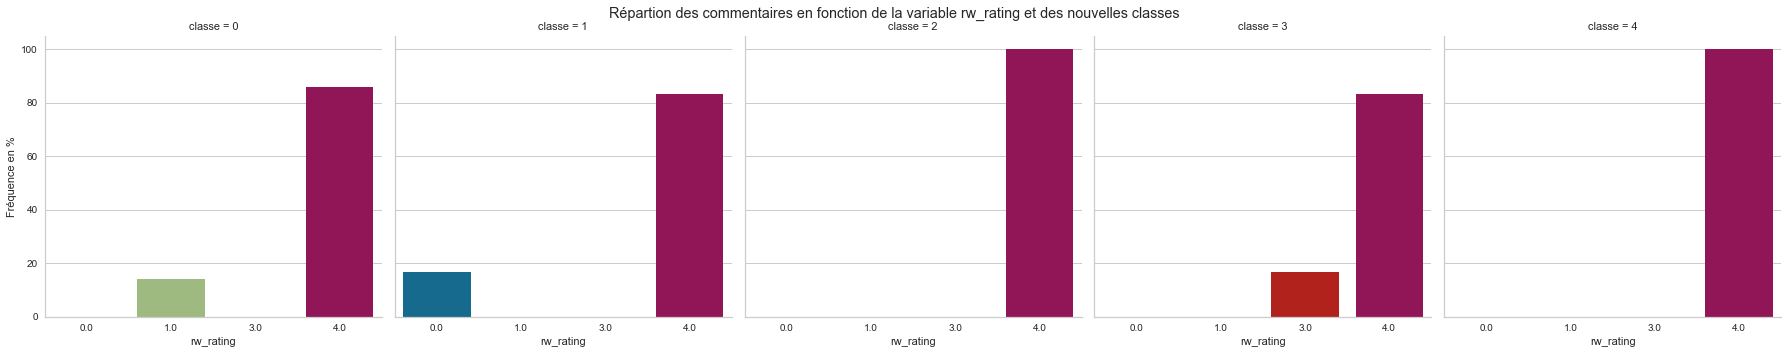

In [380]:
t = pd.crosstab(df_km.rw_rating,
                df_km.classe,
                normalize="columns")
t = t.assign(rw_rating=t.index)
tm = pd.melt(t, id_vars="rw_rating")
tm = tm.assign(value=100 * tm.value)
ax=sns.catplot(x="rw_rating",
               y="value", 
               col="classe",
               data=tm,
               kind="bar")
ax.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
ax.fig.suptitle("Répartion des commentaires en fonction de la variable rw_rating et des nouvelles classes")
ax.set_axis_labels("rw_rating","Fréquence en %")
plt.show()

### DBScan

In [443]:
X = StandardScaler().fit_transform(X)

In [452]:
X = df_acp2.copy()

In [453]:
X

,feeling_neg,feeling_neu,compound,feeling_pos,americans,appetizers,area,arrondissement,bit,boo,...,thanks_tfidf,tiles_tfidf,time_tfidf,wait_tfidf,walk_tfidf,warren_tfidf,wowwe_tfidf,yelpers_tfidf,tsne-2d-one,tsne-2d-two
0,0.000,1.000,0.0000,0.000,0,0,0,0,0,2,...,0.000000,0.000000,0.000000,0.337569,0.000000,0.00000,0.000000,0.000000,-47.150333,-25.387846
1,0.047,0.389,0.9230,0.564,0,0,0,0,0,0,...,0.340622,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,41.741367,43.305309
2,0.000,0.625,0.7778,0.375,1,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,-384.060608,-315.099335
3,0.000,0.878,0.2023,0.122,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,67.663643,-5.492392
4,0.000,0.000,0.0000,0.000,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,61.151062,-62.968292
5,0.000,1.000,0.0000,0.000,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.364338,0.00000,0.000000,0.000000,-42.187996,41.159809
6,0.117,0.643,0.4767,0.240,0,0,0,1,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.57735,0.000000,0.000000,-62.566071,-86.085739
7,0.077,0.442,0.8074,0.481,0,0,1,0,0,0,...,0.000000,0.408248,0.000000,0.000000,0.000000,0.00000,0.408248,0.000000,10.212450,138.636124
8,0.000,0.558,0.8591,0.442,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,107.248543,-100.698723
9,0.000,0.632,0.7506,0.368,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,52.335278,96.977463


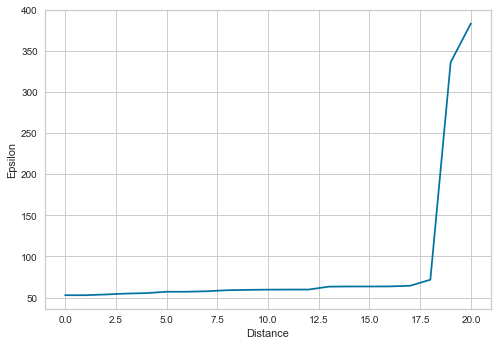

In [469]:
# we use nearestneighbors for calculating distance between points
from sklearn.neighbors import NearestNeighbors
# calculating distances
neigh=NearestNeighbors(n_neighbors=3)
distance=neigh.fit(X)
# indices and distance values
distances,indices=distance.kneighbors(X)
# Now sorting the distance increasing order
sorting_distances=np.sort(distances,axis=0)
# sorted distances
sorted_distances=sorting_distances[:,1]
# plot between distance vs epsilon
plt.plot(sorted_distances)
plt.xlabel('Distance')
plt.ylabel('Epsilon')
plt.show()

In [470]:
from sklearn.cluster import DBSCAN
# intializing DBSCAN
clustering_model=DBSCAN(eps=85,min_samples=4)
# fit the model to X
db = clustering_model.fit(X)
# predicted labels by DBSCAN
predicted_labels=clustering_model.labels_


In [471]:
from sklearn import metrics
metrics.silhouette_score(X, predicted_labels)

0.5931241408190205

In [472]:
for i in X.columns:
    print(i)

feeling_neg
feeling_neu
compound
feeling_pos
americans
appetizers
area
arrondissement
bit
boo
bowl
cafe
call
cluster
cochon
confit
corner
cous
cuisine
decadence
decor
dine
dining
distance
drinks
du
eateries
experience
food
fumoir
funky
guidance
health
history
hotel
hours
instance
location
louvre
lowkey
luck
lunch
lunchtime
meal
menu
minute
museum
neighborhood
night
nothing
okay
outdoor
parisian
pass
pasta
people
place
places
poke
pots
prices
reservation
restaurant
reviewers
rooms
rush
salad
seafood
serve
server
service
setting
setup
share
solo
someone
soup
spot
staff
stars
sthonore
tartare
tearsofhappinesswe
terrace
thanks
tiles
time
wait
walk
warren
wowwe
yelpers
americans_tfidf
appetizers_tfidf
area_tfidf
arrondissement_tfidf
bit_tfidf
boo_tfidf
bowl_tfidf
cafe_tfidf
call_tfidf
cluster_tfidf
cochon_tfidf
confit_tfidf
corner_tfidf
cous_tfidf
cuisine_tfidf
decadence_tfidf
decor_tfidf
dine_tfidf
dining_tfidf
distance_tfidf
drinks_tfidf
du_tfidf
eateries_tfidf
experience_tfidf
food_tfidf

<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

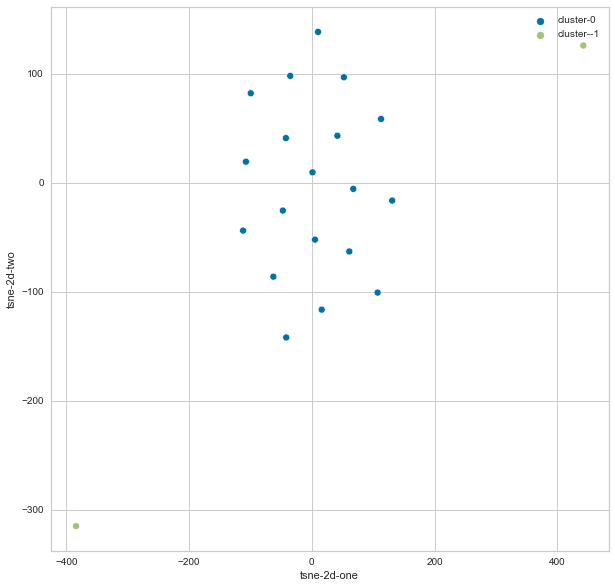

In [473]:
labels = clustering_model.labels_
fig = plt.figure(figsize=(10, 10))
sns.scatterplot(X['tsne-2d-one'], X['tsne-2d-two'], hue=["cluster-{}".format(x) for x in labels])